## Experiments list

0) Exploratory data analysis (EDA)    
1) Experiments with pretrained text encoders + KNN Classifier    
2-4) Domain Adaptation: fine-tuning text encoders with Online Constrative Loss, Multiple Negatives Ranking Loss and CrossEntropyLoss    

## Import and settings

In [ ]:
!pip install sentence_transformers
!pip install -U FlagEmbedding
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from typing import Callable, Dict, Iterable, Tuple, Type
from tqdm.autonotebook import trange
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from itertools import combinations
from datetime import datetime
import seaborn as sns
import operator
import logging
import math
import random
import json
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer

<ipython-input-2-7d9cd82484c7>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from transformers.pipelines import pipeline
from transformers import AutoTokenizer, AutoModel
from transformers import is_torch_npu_available
from sentence_transformers.evaluation import SentenceEvaluator
from sentence_transformers.util import batch_to_device, fullname
from sentence_transformers.model_card_templates import ModelCardTemplate
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, InputExample, util, evaluation, SentencesDataset
from FlagEmbedding import BGEM3FlagModel

In [ ]:
def seed_everything(seed = 42):
     random.seed(seed)
     os.environ['PYTHONHASHSEED'] = str(seed)  # int(os.environ.get('PYTHONHASHSEED'))
     np.random.seed(seed)
     torch.manual_seed(seed)
     torch.cuda.manual_seed(seed)
     torch.backends.cudnn.deterministic = True

seed_everything()

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


# 0 EDA

### train dataset

In [ ]:
directory_train = "/content/gdrive/MyDrive/datasets/sravni/intents_prepared.json"

In [ ]:
with open(directory_train, 'r') as f:
    data = json.load(f)

df_train = pd.DataFrame(data)

In [ ]:
df_train.drop(columns=["intent_id"], inplace=True)
df_train.rename(columns={"intent_path":"intent", "phrase":"request"}, inplace=True)
df_train.head()

intent  \
0  /Пересекающиеся/Продлить полис   
1  /Пересекающиеся/Продлить полис   
2  /Пересекающиеся/Продлить полис   
3  /Пересекающиеся/Продлить полис   
4  /Пересекающиеся/Продлить полис   

                                        request  
0                          продлить полис осаго  
1                      мне нужно продлить полис  
2          нам нужно продлить полис страхования  
3  каким образом я могу продлить полис осаго от  
4                   помогите продлить страховку

In [ ]:
df_train.duplicated().any()

False

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7964 entries, 0 to 7963
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   intent   7964 non-null   object
 1   request  7964 non-null   object
dtypes: object(2)
memory usage: 186.7+ KB


In [ ]:
# Checking for Line Breaks ("\n")
def search_symbol_in_words(symbol, word_list):
    found_words = []
    for word in word_list:
        if symbol in word:
            found_words.append(word)
    return found_words

words = list(df_train["intent"])
symbol_to_find = "\n"
found_words = search_symbol_in_words(symbol_to_find, words)
print("Words containing the symbol '{}':".format(symbol_to_find))
print(found_words)

Words containing the symbol '
':
[]


In [ ]:
print("Unique intents:", len(df_train["intent"].unique()))

Unique intents: 183


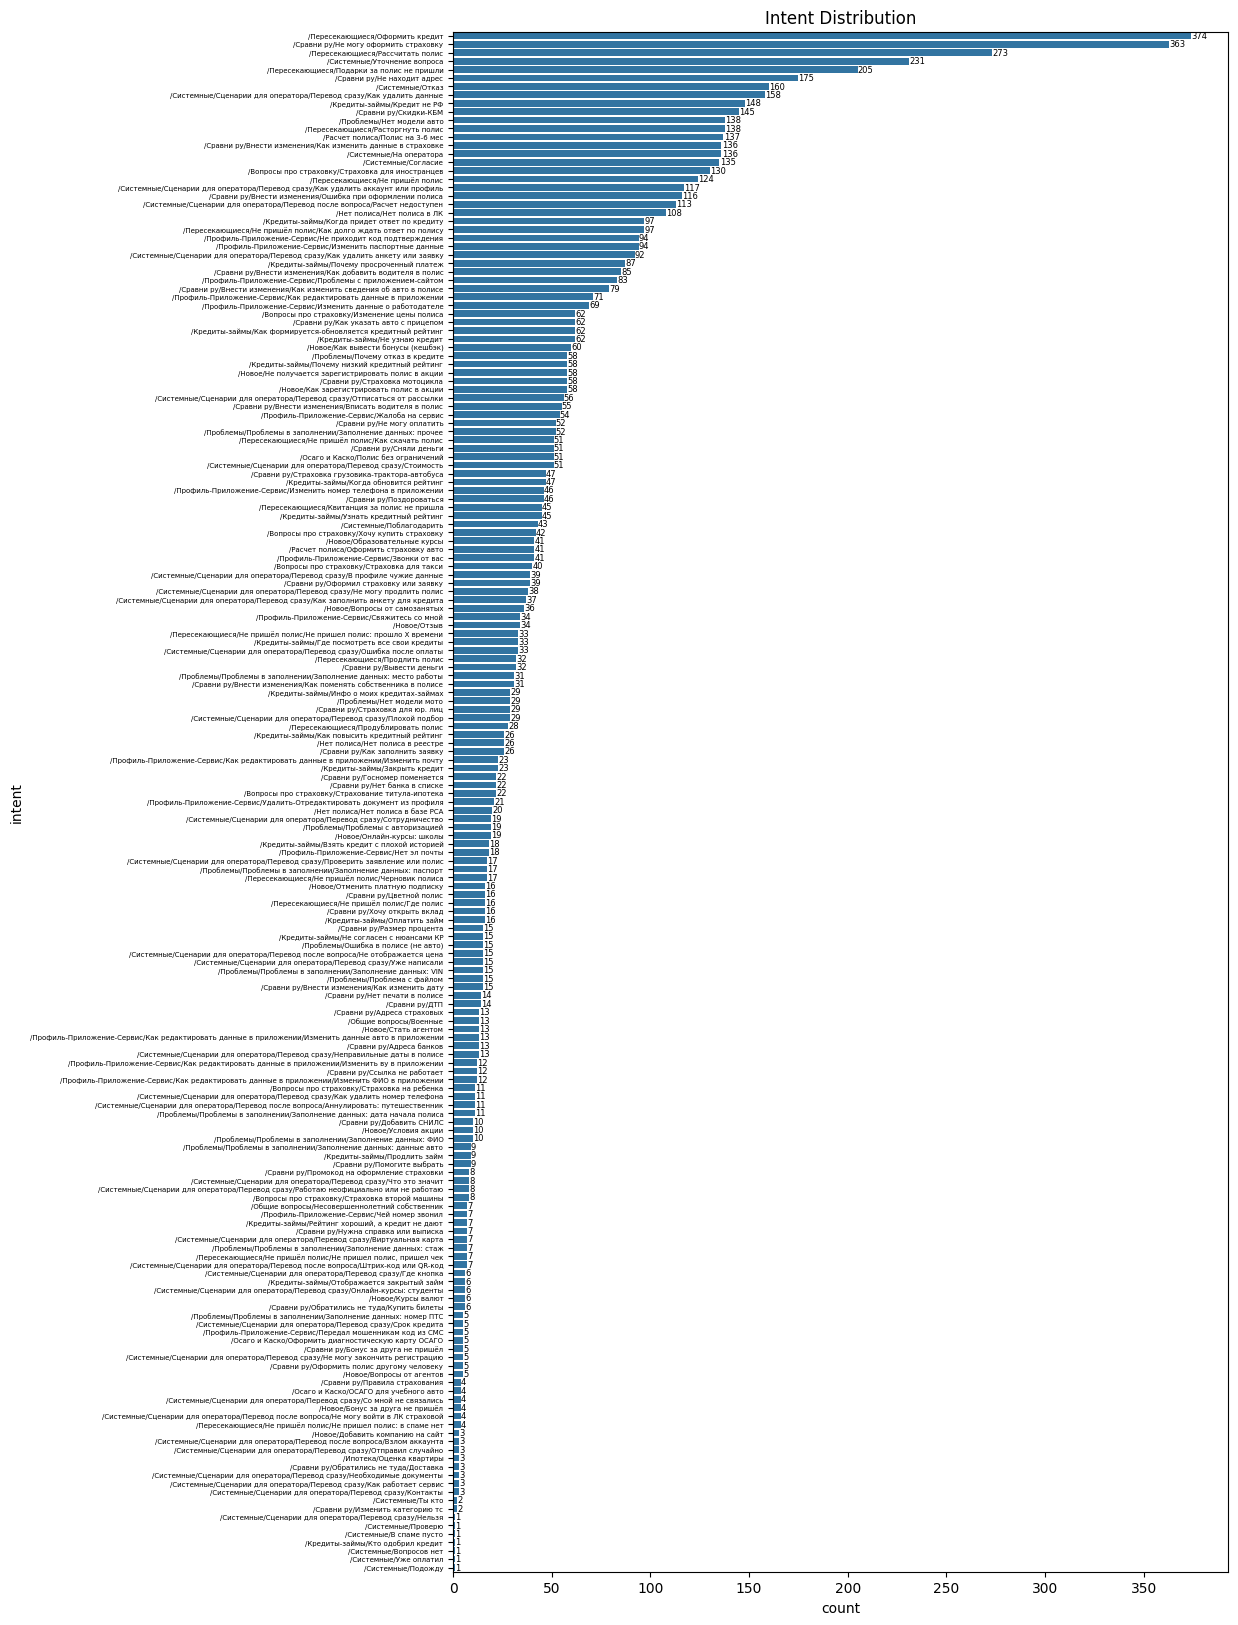

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 20))

order = df_train['intent'].value_counts().index

sns.countplot(y="intent", data=df_train, order=order, linewidth=1,
              alpha=1, ax=axes)
axes.set_title("Intent Distribution")
axes.set_xlabel("count")
axes.set_ylabel("intent")

# Adjusting y-axis
axes.set_yticks(range(len(order)))
axes.set_yticklabels(order, fontsize=5)

# Add labels above each bar
for index, value in enumerate(df_train['intent'].value_counts()):
    axes.text(value+0.1, index, str(value), ha='left', va='center', fontsize=6)

plt.show()

In [ ]:
# (As a percentage)
print(df_train.intent.value_counts(normalize=True))

intent
/Пересекающиеся/Оформить кредит               0.046961
/Сравни ру/Не могу оформить страховку         0.045580
/Пересекающиеся/Рассчитать полис              0.034279
/Системные/Уточнение вопроса                  0.029006
/Пересекающиеся/Подарки за полис не пришли    0.025741
                                                ...   
/Системные/В спаме пусто                      0.000126
/Кредиты-займы/Кто одобрил кредит             0.000126
/Системные/Вопросов нет                       0.000126
/Системные/Уже оплатил                        0.000126
/Системные/Подожду                            0.000126
Name: proportion, Length: 183, dtype: float64


In [ ]:
# Number words
print("Number words in dataset:", len(
    " ".join(df_train.request.tolist()).split()))

Number words in dataset: 60011


In [ ]:
# Vocabulary size
vocab_size = len(set(" ".join(df_train.request.tolist()).split()))
print("Vocabulary size: ", vocab_size)

Vocabulary size:  6254


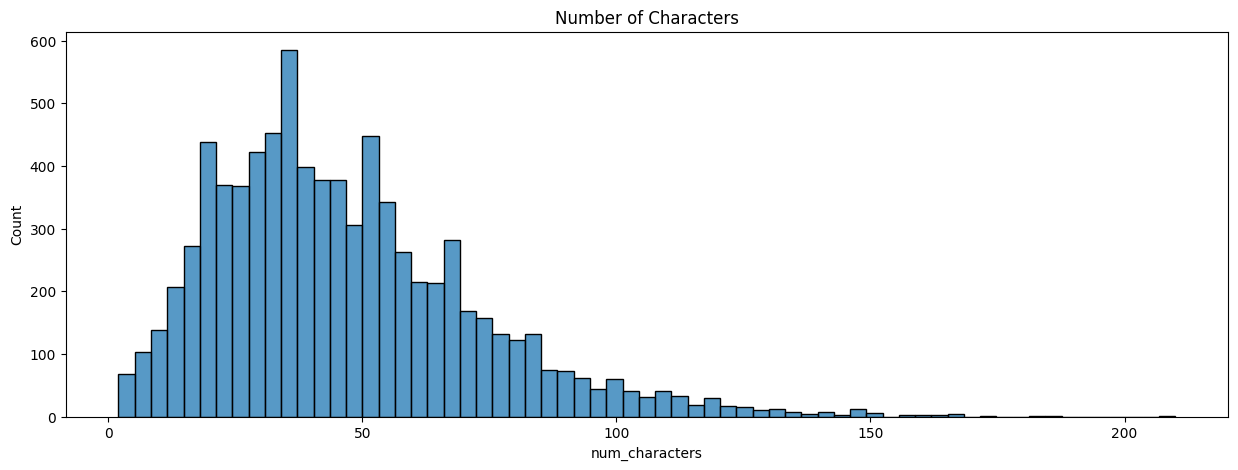

In [ ]:
# Number of Characters
fig = plt.figure(figsize=(15, 5))
df_train["num_characters"] = df_train["request"].str.len()

sns.histplot(data=df_train, x="num_characters")
plt.title("Number of Characters")
plt.show()

In [ ]:
df_train["num_characters"].describe()

count    7964.000000
mean       46.285912
std        25.783281
min         2.000000
25%        28.000000
50%        42.000000
75%        60.000000
max       210.000000
Name: num_characters, dtype: float64

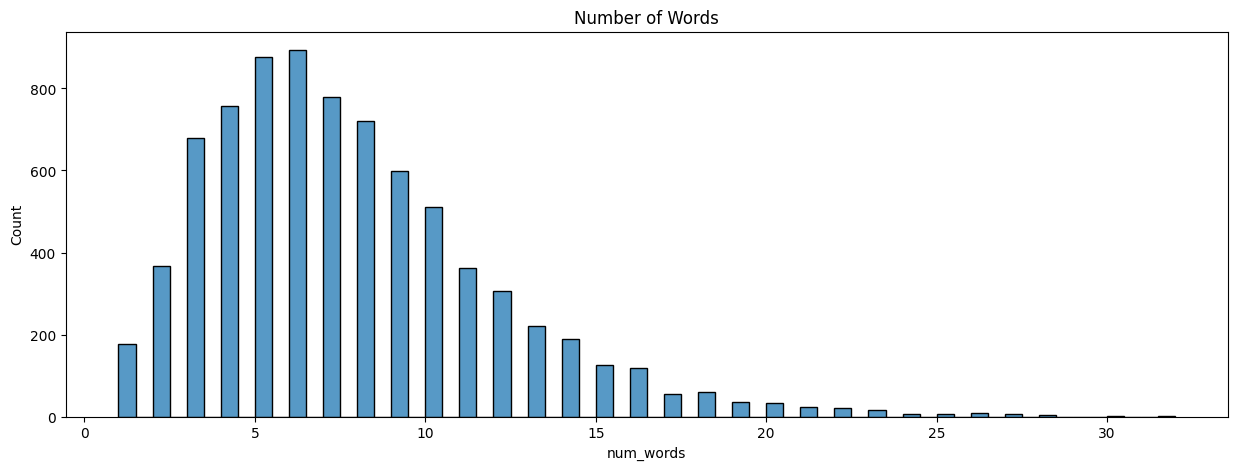

In [ ]:
# Number of Words
fig = plt.figure(figsize=(15, 5))
df_train["num_words"] = df_train["request"].apply(
    lambda x: len(str(x).split()))
sns.histplot(data=df_train, x="num_words")
plt.title("Number of Words")
plt.show()

In [ ]:
df_train["num_words"].describe()

count    7964.000000
mean        7.535284
std         4.212268
min         1.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        32.000000
Name: num_words, dtype: float64

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


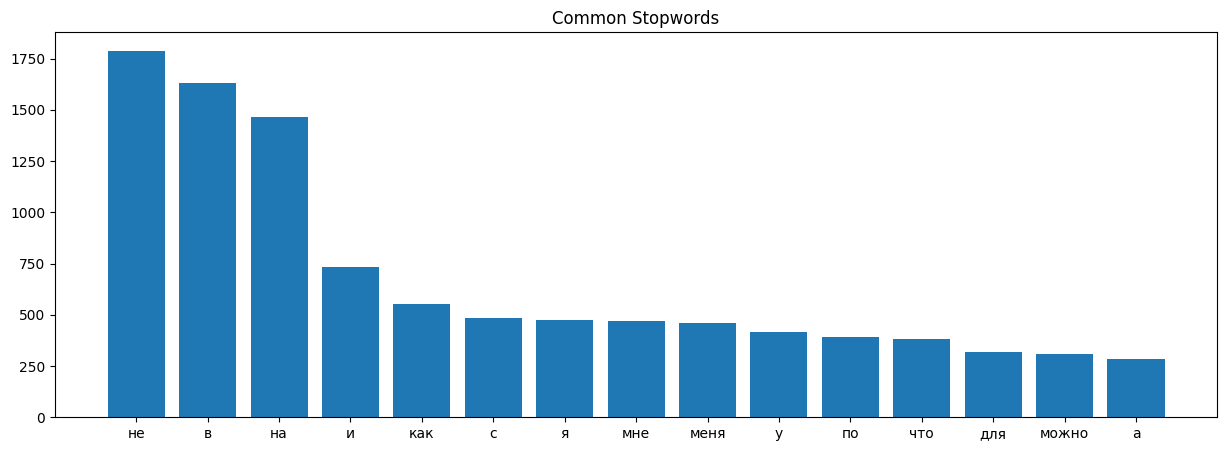

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
nltk.download("stopwords")

# Common Stopwords
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words("russian"))
corpus = "".join(map(str, df_train.request)).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x, y = zip(*top_words)
plt.bar(x, y)
plt.title("Common Stopwords")
plt.show()

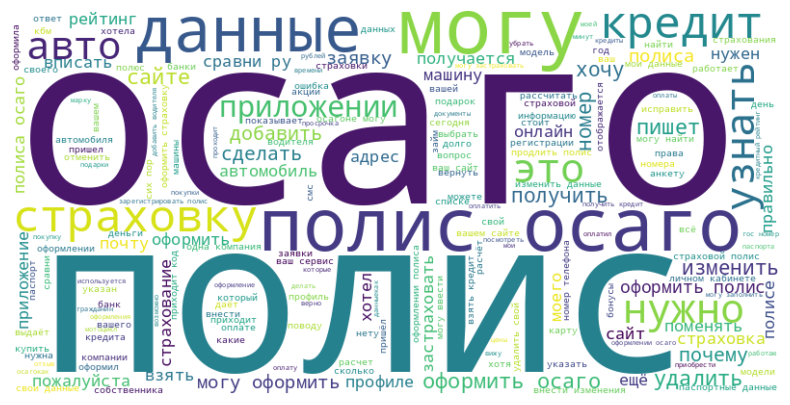

In [ ]:
from wordcloud import WordCloud

# Word Cloud (without stopwords!)
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(
    "".join(map(str, df_train.request)))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_train.drop(columns=["num_characters", "num_words"], inplace=True)

In [ ]:
df_train.to_csv('sravni_train.csv', index=False, encoding='utf-8')

### test dataset

In [ ]:
directory_test = "/content/gdrive/MyDrive/datasets/sravni/sravni_dataset_2.xlsx"

In [ ]:
df_test = pd.read_excel(directory_test)
df_test.rename(columns={"comment":"intent"}, inplace=True)
df_test.head()

intent  \
0  /Системные/Сценарии для оператора/Перевод сраз...   
1          /Кредиты-займы/Почему просроченный платеж   
2  /Сравни ру/Внести изменения/Как изменить сведе...   
3                    /Пересекающиеся/Не пришёл полис   
4                      /Кредиты-займы/Закрыть кредит   

                                             request  
0  Прошу убрать из рассылок любого характера мой ...  
1  Здравствуйте. Я брал займ в мфо через приложен...  
2  Добрый день. Я оформила полис ОСАГО на вашем с...  
3  Два дня назад оплатил осаго, через сравни ру д...  
4  Здравствуйте, я через вас взял займ в миг кред...

In [ ]:
df_test.duplicated().any()

True

Let's eliminate duplicates:

In [ ]:
df_test = df_test.drop_duplicates(subset=['request'])
df_test = df_test.reset_index(drop=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   intent   591 non-null    object
 1   request  591 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [ ]:
# Checking for Line Breaks ("\n")
def search_symbol_in_words(symbol, word_list):
    found_words = []
    for word in word_list:
        if symbol in word:
            found_words.append(word)
    return found_words

words = list(df_test["intent"])
symbol_to_find = "\n"
found_words = search_symbol_in_words(symbol_to_find, words)
print("Words containing the symbol '{}':".format(symbol_to_find))
print(found_words)

Words containing the symbol '
':
[]


In [ ]:
print("Unique intents:", len(df_test["intent"].unique()))

Unique intents: 102


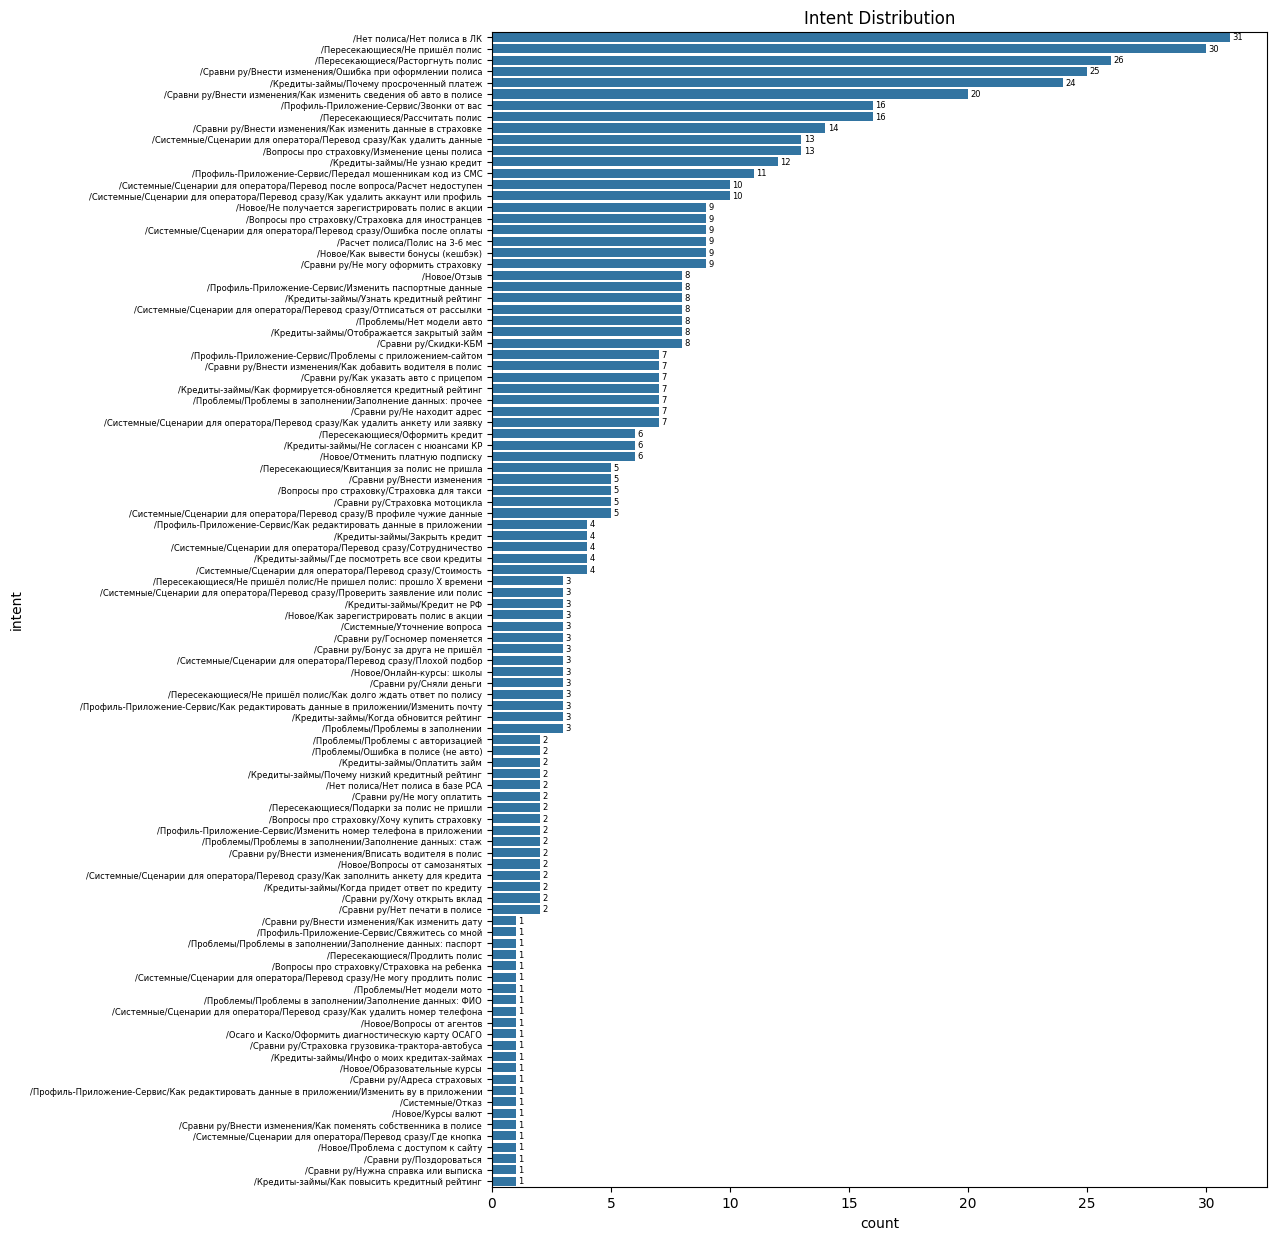

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 15))

order = df_test['intent'].value_counts().index

sns.countplot(y="intent", data=df_test, order=order, linewidth=1,
              alpha=1, ax=axes)
axes.set_title("Intent Distribution")
axes.set_xlabel("count")
axes.set_ylabel("intent")

# Adjusting y-axis
axes.set_yticks(range(len(order)))
axes.set_yticklabels(order, fontsize=6)

# Add labels above each bar
for index, value in enumerate(df_test['intent'].value_counts()):
    axes.text(value+0.1, index, str(value), ha='left', va='center', fontsize=6)

plt.show()

In [ ]:
# (As a percentage)
print(df_test.intent.value_counts(normalize=True))

intent
/Нет полиса/Нет полиса в ЛК                                   0.052453
/Пересекающиеся/Не пришёл полис                               0.050761
/Пересекающиеся/Расторгнуть полис                             0.043993
/Сравни ру/Внести изменения/Ошибка при оформлении полиса      0.042301
/Кредиты-займы/Почему просроченный платеж                     0.040609
                                                                ...   
/Системные/Сценарии для оператора/Перевод сразу/Где кнопка    0.001692
/Новое/Проблема с доступом к сайту                            0.001692
/Сравни ру/Поздороваться                                      0.001692
/Сравни ру/Нужна справка или выписка                          0.001692
/Кредиты-займы/Как повысить кредитный рейтинг                 0.001692
Name: proportion, Length: 102, dtype: float64


In [ ]:
# Number words
print("Number words in dataset:", len(
    " ".join(df_test.request.tolist()).split()))

Number words in dataset: 10527


In [ ]:
# Vocabulary size
vocab_size = len(set(" ".join(df_test.request.tolist()).split()))
print("Vocabulary size: ", vocab_size)

Vocabulary size:  3580


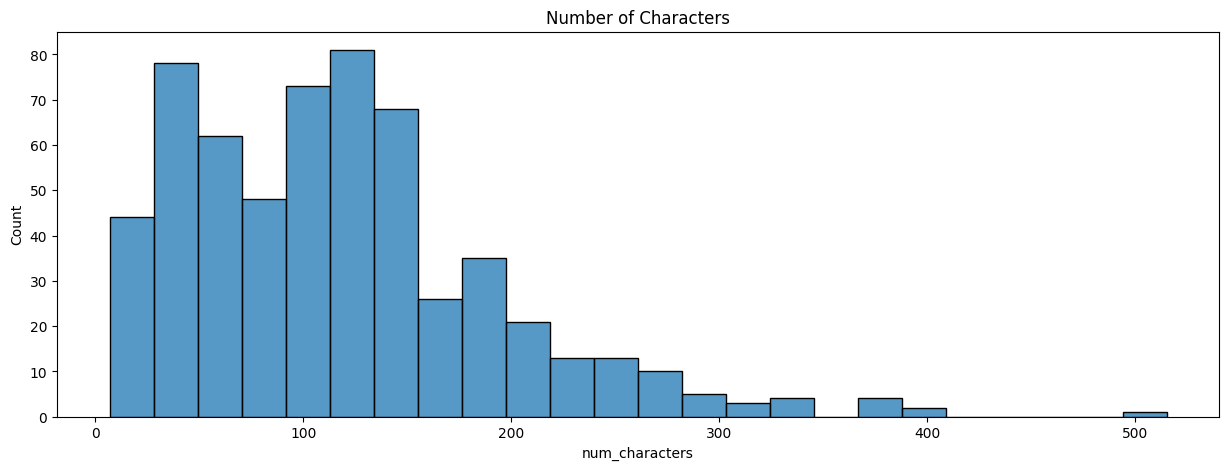

In [ ]:
# Number of Characters
fig = plt.figure(figsize=(15, 5))
df_test["num_characters"] = df_test["request"].str.len()

sns.histplot(data=df_test, x="num_characters")
plt.title("Number of Characters")
plt.show()

In [ ]:
df_test["num_characters"].describe()

count    591.000000
mean     117.426396
std       74.847490
min        7.000000
25%       57.000000
50%      110.000000
75%      149.500000
max      515.000000
Name: num_characters, dtype: float64

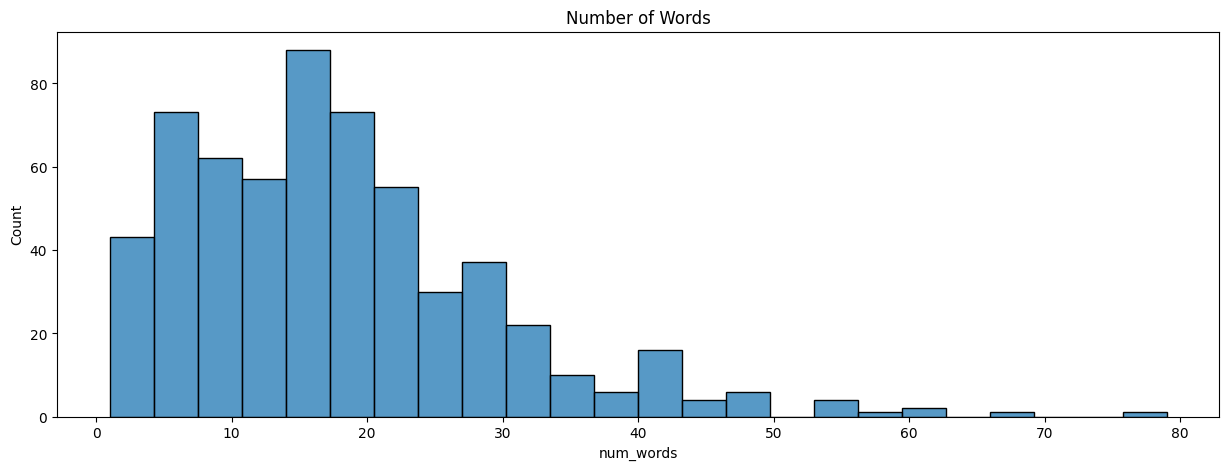

In [ ]:
# Number of Words
fig = plt.figure(figsize=(15, 5))
df_test["num_words"] = df_test["request"].apply(
    lambda x: len(str(x).split()))
sns.histplot(data=df_test, x="num_words")
plt.title("Number of Words")
plt.show()

In [ ]:
df_test["num_words"].describe()

count    591.000000
mean      17.812183
std       11.466691
min        1.000000
25%        9.000000
50%       16.000000
75%       23.000000
max       79.000000
Name: num_words, dtype: float64

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


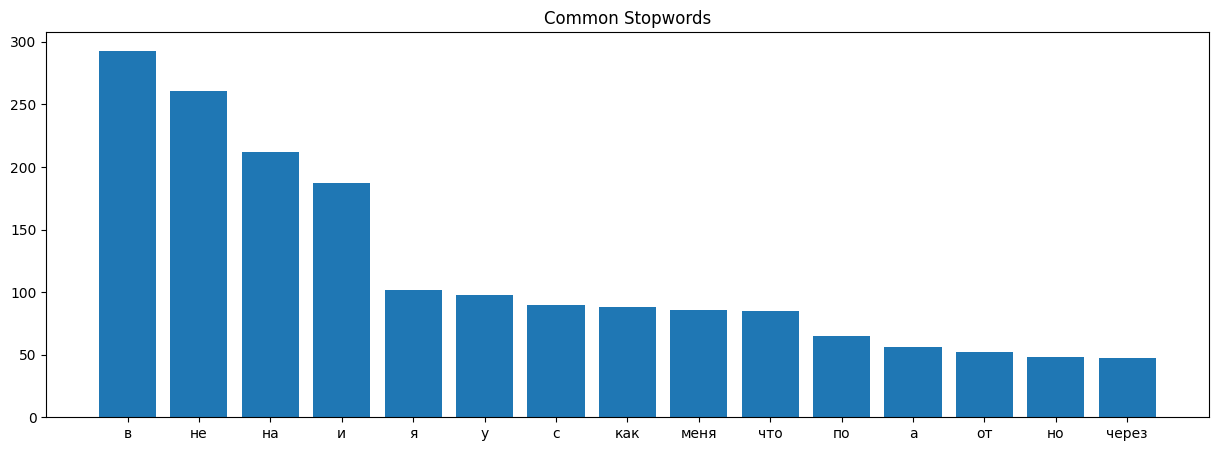

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
nltk.download("stopwords")

# Common Stopwords
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words("russian"))
corpus = "".join(map(str, df_test.request)).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x, y = zip(*top_words)
plt.bar(x, y)
plt.title("Common Stopwords")
plt.show()

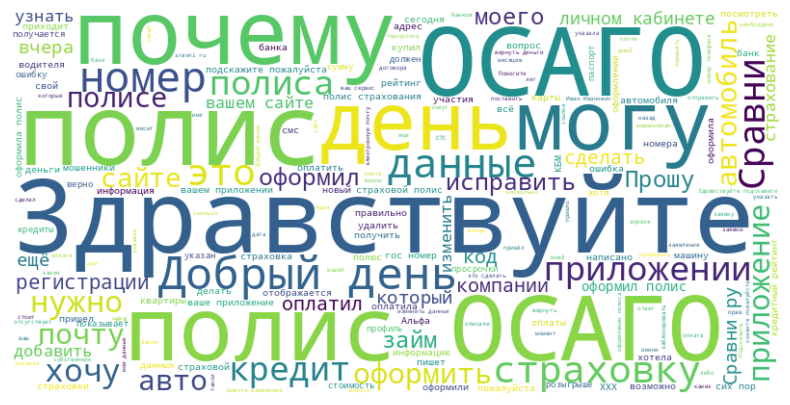

In [ ]:
from wordcloud import WordCloud

# Word Cloud (without stopwords!)
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(
    "".join(map(str, df_test.request)))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_test.drop(columns=["num_characters", "num_words"], inplace=True)

In [ ]:
df_test.to_csv('sravni_test.csv', index=False, encoding='utf-8')

# 1 Pretrained text encoders + KNN Classifier

## Load and split dataset

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/datasets/sravni/sravni_train.csv')
train.head()

intent  \
0  /Пересекающиеся/Продлить полис   
1  /Пересекающиеся/Продлить полис   
2  /Пересекающиеся/Продлить полис   
3  /Пересекающиеся/Продлить полис   
4  /Пересекающиеся/Продлить полис   

                                        request  
0                          продлить полис осаго  
1                      мне нужно продлить полис  
2          нам нужно продлить полис страхования  
3  каким образом я могу продлить полис осаго от  
4                   помогите продлить страховку

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/datasets/sravni/sravni_test.csv')
test.head()

intent  \
0  /Системные/Сценарии для оператора/Перевод сраз...   
1          /Кредиты-займы/Почему просроченный платеж   
2  /Сравни ру/Внести изменения/Как изменить сведе...   
3                    /Пересекающиеся/Не пришёл полис   
4                      /Кредиты-займы/Закрыть кредит   

                                             request  
0  Прошу убрать из рассылок любого характера мой ...  
1  Здравствуйте. Я брал займ в мфо через приложен...  
2  Добрый день. Я оформила полис ОСАГО на вашем с...  
3  Два дня назад оплатил осаго, через сравни ру д...  
4  Здравствуйте, я через вас взял займ в миг кред...

In [ ]:
x_train, x_test, y_train, y_test = train["request"].to_list(), test["request"].to_list(), train["intent"].to_list(), test["intent"].to_list()

In [ ]:
intents_name = list(set(y_train) | set(y_test))

## m-e5-large

https://huggingface.co/intfloat/multilingual-e5-large

In [ ]:
model_name = 'intfloat/multilingual-e5-large'
embedder_e5 = SentenceTransformer(model_name, prompts={
        "classification": "Classify the following text: "
        }, default_prompt_name="classification")

Let's generate embeddings from the dataset:

In [ ]:
embeddings_requests_e5_train = embedder_e5.encode(x_train, normalize_embeddings=True, convert_to_tensor=True).to("cpu")
embeddings_requests_e5_test = embedder_e5.encode(x_test, normalize_embeddings=True, convert_to_tensor=True).to("cpu")

Let's plot the dependency graph of F1-macro on the number of neighbors (K):

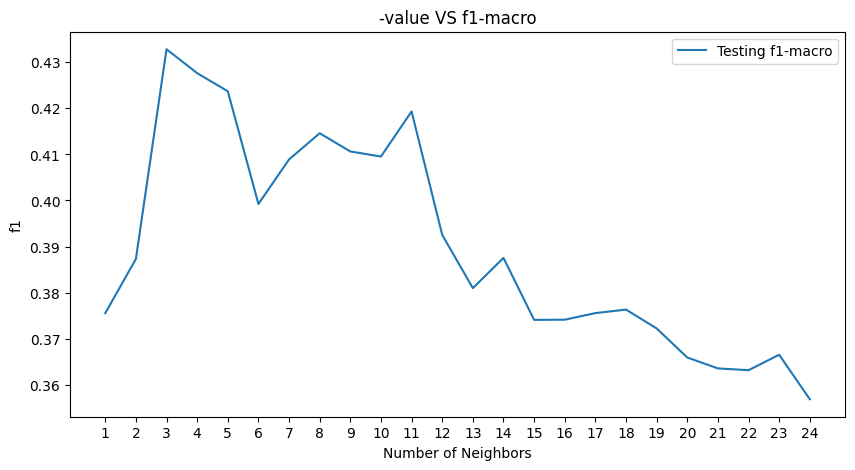

Best f1 is 0.4328192212688245 with K = 3


In [ ]:
# Model complexity
neig = np.arange(1, 25)
test_f1 = []

# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(embeddings_requests_e5_train, y_train)
    # Predict with knn
    prediction = knn.predict(embeddings_requests_e5_test)
    # test f1
    test_f1.append(f1_score(y_test, prediction, average='macro'))

# Plot
plt.figure(figsize=[10, 5])
plt.plot(neig, test_f1, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best f1 is {} with K = {}".format(np.max(test_f1), 1+test_f1.index(np.max(test_f1))))

Let's train the KNN classifier:

In [ ]:
K = 3  # Number of neighbors

# KNN-model
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
knn.fit(embeddings_requests_e5_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [ ]:
prediction = knn.predict(embeddings_requests_e5_test)
f1_macro = f1_score(y_test, prediction, average='macro')  # f1-macro
print(f'With KNN (K={K}) f1-macro is: ', f1_macro)
print(f'With KNN (K={K}) accuracy is: ', knn.score(embeddings_requests_e5_test, y_test))

With KNN (K=3) f1-macro is:  0.4328192212688245
With KNN (K=3) accuracy is:  0.5482233502538071


Let's visualize the clusters of embeddings:



In [ ]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    A function for visualizing the results of t-SNE
        :param data: features
        :param n_iter: the number of iterations for gradient descent,
            could be beneficial to increase to obtain better results
        :param perplexity: the number of neighbors
        :param color: np.array[n_samples] with variable,
            that we want to use to color our observations
        :return tsne_emb: np.array[n_samples, 2] - the results of t-SNE
    """

    # Let's start with PCA, as it provides a good initial approximation for t-SNE
    # This will allow the algorithm to converge faster
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)


    # Let's run t-SNE, it will give us 2 numbers for each object,
    # which we can to draw
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=int(os.environ.get('PYTHONHASHSEED')))
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # We will also return the results of t-SNE
    return tsne_embedding

<ipython-input-16-bbb6db1f7fd8>:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


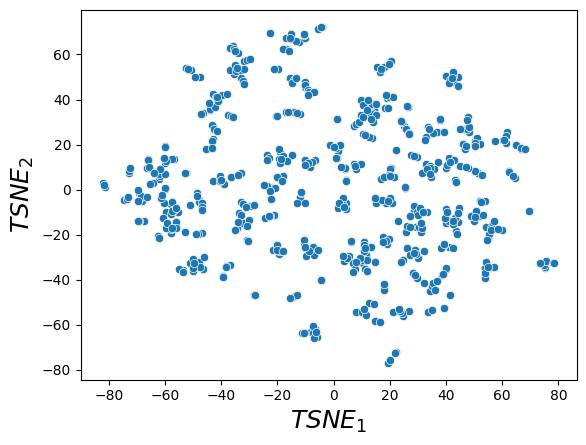

In [ ]:
tsne_test_requests_e5 = plot_tsne(embeddings_requests_e5_test,
                                  perplexity=K);

Let's color-code the predicted and ground truth intents differently:

In [ ]:
# Encoding text labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents_name)

# Color dictionary for labels
color_dict = {intents_name[i]: encoded_labels[i] for i in range(len(encoded_labels))}

# Creating a t-SNE plot for the first graph
trace1 = go.Scatter(x=tsne_test_requests_e5[:, 0],
                    y=tsne_test_requests_e5[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in prediction], colorscale='Jet', opacity=1),
                    text=prediction,
                    showlegend=False)

# Creating a t-SNE plot for the second graph
trace2 = go.Scatter(x=tsne_test_requests_e5[:, 0],
                    y=tsne_test_requests_e5[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in y_test], colorscale='Jet', opacity=1),
                    text=y_test,
                    showlegend=False)

# Layout adjustments
layout1 = go.Layout(width=100, height=100)
layout2 = go.Layout(width=100, height=100)

# Creating figure for each graph
fig1 = go.Figure(data=[trace1], layout=layout1)
fig2 = go.Figure(data=[trace2], layout=layout2)

# Setting up subplot grid
fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Ground Truth"))

# Adding plots to a grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.show()

## bge-m3

https://huggingface.co/BAAI/bge-m3

In [ ]:
embedder_bge = BGEM3FlagModel('BAAI/bge-m3')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Let's generate embeddings from the dataset:

In [ ]:
embeddings_requests_bge_train = embedder_bge.encode(x_train)['dense_vecs']
embeddings_requests_bge_test = embedder_bge.encode(x_test)['dense_vecs']

Inference Embeddings: 100%|██████████| 50/50 [00:01<00:00, 34.88it/s]


Let's plot the dependency graph of F1-macro on the number of neighbors (K):

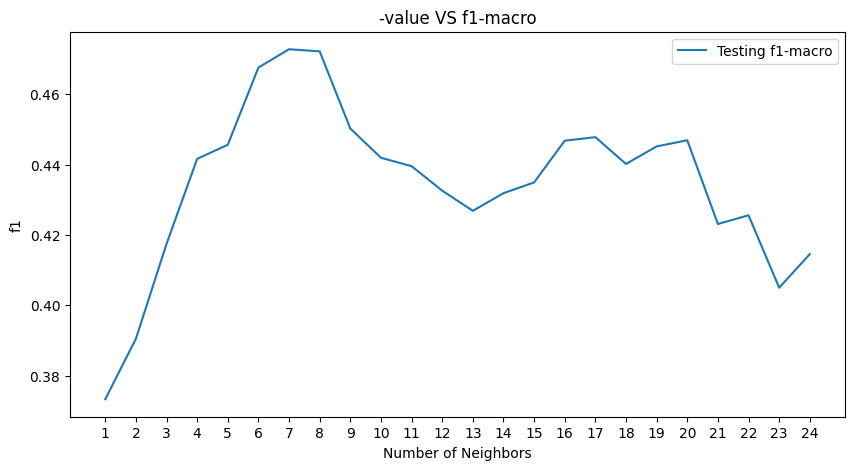

Best f1 is 0.47283172470712387 with K = 7


In [ ]:
# Model complexity
neig = np.arange(1, 25)
test_f1 = []

# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(embeddings_requests_bge_train, y_train)
    # Predict with knn
    prediction = knn.predict(embeddings_requests_bge_test)
    # test f1
    test_f1.append(f1_score(y_test, prediction, average='macro'))

# Plot
plt.figure(figsize=[10, 5])
plt.plot(neig, test_f1, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best f1 is {} with K = {}".format(np.max(test_f1), 1+test_f1.index(np.max(test_f1))))

Let's train the KNN classifier:

In [ ]:
K = 7  # Number of neighbors

# KNN-model
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
knn.fit(embeddings_requests_bge_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7)

In [ ]:
prediction = knn.predict(embeddings_requests_bge_test)
f1_macro = f1_score(y_test, prediction, average='macro')  # f1-macro
print(f'With KNN (K={K}) f1-macro is: ', f1_macro)
print(f'With KNN (K={K}) accuracy is: ', knn.score(embeddings_requests_bge_test, y_test))

With KNN (K=7) f1-macro is:  0.47283172470712387
With KNN (K=7) accuracy is:  0.5939086294416244


<ipython-input-72-2cb600546557>:26: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



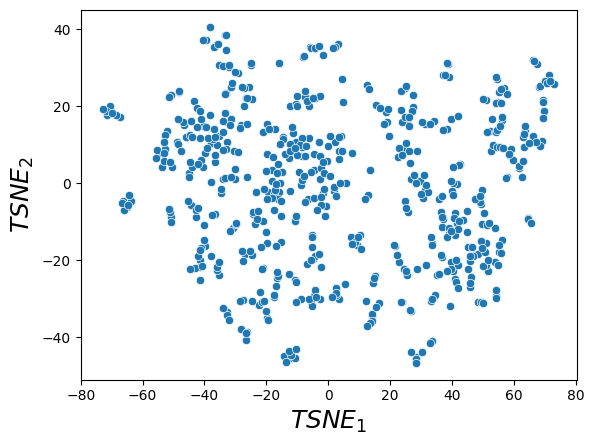

In [ ]:
tsne_test_requests_bge = plot_tsne(embeddings_requests_bge_test,
                                   perplexity=K);

In [ ]:
# Encoding text labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents_name)

# Color dictionary for labels
color_dict = {intents_name[i]: encoded_labels[i] for i in range(len(encoded_labels))}

# Creating a t-SNE plot for the first graph
trace1 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in prediction], colorscale='Jet', opacity=1),
                    text=prediction,
                    showlegend=False)

# Creating a t-SNE plot for the second graph
trace2 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in y_test], colorscale='Jet', opacity=1),
                    text=y_test,
                    showlegend=False)

# Layout adjustments
layout1 = go.Layout(width=100, height=100)
layout2 = go.Layout(width=100, height=100)

# Creating figure for each graph
fig1 = go.Figure(data=[trace1], layout=layout1)
fig2 = go.Figure(data=[trace2], layout=layout2)

# Setting up subplot grid
fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Ground Truth"))

# Adding plots to a grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.show()

# 2 Fine-tuning sentence encoder (using SentenceTransformer) with OnlineConstrativeLoss

### Load and Prune dataset

We will fine-tune the model on a 'prunned' dataset to save computing resources.

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/datasets/sravni/sravni_train.csv')
train.head()

intent  \
0  /Пересекающиеся/Продлить полис   
1  /Пересекающиеся/Продлить полис   
2  /Пересекающиеся/Продлить полис   
3  /Пересекающиеся/Продлить полис   
4  /Пересекающиеся/Продлить полис   

                                        request  
0                          продлить полис осаго  
1                      мне нужно продлить полис  
2          нам нужно продлить полис страхования  
3  каким образом я могу продлить полис осаго от  
4                   помогите продлить страховку

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/datasets/sravni/sravni_test.csv')
test.head()

intent  \
0  /Системные/Сценарии для оператора/Перевод сраз...   
1          /Кредиты-займы/Почему просроченный платеж   
2  /Сравни ру/Внести изменения/Как изменить сведе...   
3                    /Пересекающиеся/Не пришёл полис   
4                      /Кредиты-займы/Закрыть кредит   

                                             request  
0  Прошу убрать из рассылок любого характера мой ...  
1  Здравствуйте. Я брал займ в мфо через приложен...  
2  Добрый день. Я оформила полис ОСАГО на вашем с...  
3  Два дня назад оплатил осаго, через сравни ру д...  
4  Здравствуйте, я через вас взял займ в миг кред...

In [ ]:
N = 10  # dataset pruning threshold

# Group the data by class and save only N values for each class, where the number of values exceeds N.
train_pruned = train.groupby('intent').apply(lambda x: x.sample(n=N, random_state=int(os.environ.get('PYTHONHASHSEED'))) if len(x) > N else x)

# Resetting the index to obtain a DataFrame.
train_pruned = train_pruned.reset_index(drop=True)

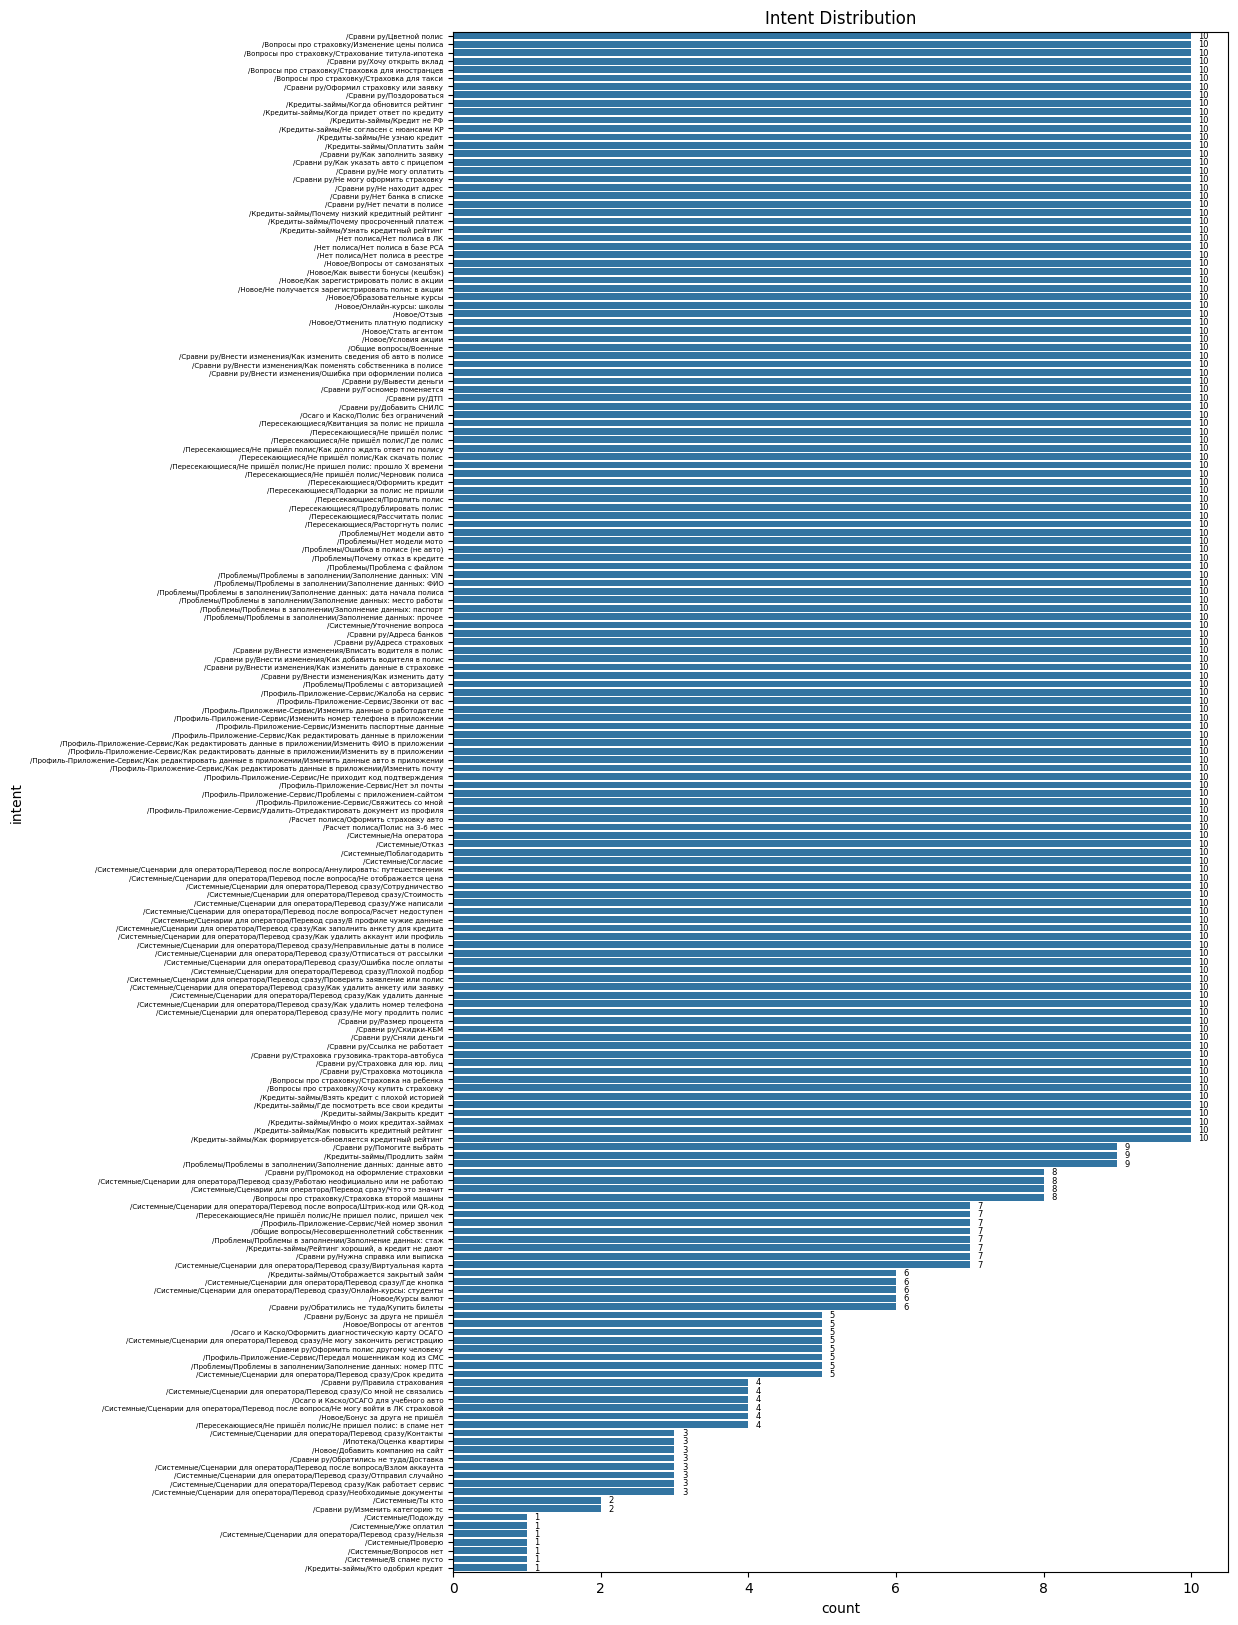

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 20))

order = train_pruned['intent'].value_counts().index

sns.countplot(y="intent", data=train_pruned, order=order, linewidth=1,
              alpha=1, ax=axes)
axes.set_title("Intent Distribution")
axes.set_xlabel("count")
axes.set_ylabel("intent")

# Adjusting y-axis
axes.set_yticks(range(len(order)))
axes.set_yticklabels(order, fontsize=5)

# Add labels above each bar
for index, value in enumerate(train_pruned['intent'].value_counts()):
    axes.text(value+0.1, index, str(value), ha='left', va='center', fontsize=6)

plt.show()

In [ ]:
train_pruned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   intent   1564 non-null   object
 1   request  1564 non-null   object
dtypes: object(2)
memory usage: 24.6+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   intent   591 non-null    object
 1   request  591 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [ ]:
intents_name = list(set(train['intent']) | set(test['intent']))
len(intents_name)

186

### m-e5-large

#### Dataset generation

##### for classification evaluator

As loss function, we use OnlineConstrativeLoss. It reduces the distance between positive pairs, i.e., it pulls the embeddings of positive pairs closer together. For negative pairs, it pushes them further apart.

In [ ]:
def generate_positive_negative_pairs(dataset):
    # Grouping texts by classes
    grouped_texts = dataset.groupby('intent')['request'].apply(list)

    positive_pairs = []
    negative_pairs = []

    # Generating positive pairs for each class
    for intent, texts in grouped_texts.items():
        # Generating all possible combinations of texts
        positive_pairs.extend(combinations(texts, 2))

    # Generating negative pairs
    intents = grouped_texts.index.tolist()
    for i, intent_a in enumerate(intents):
        for j, intent_b in enumerate(intents):
            if i != j:  # Excluding pairs from the same class
                texts_a = grouped_texts[intent_a]
                texts_b = grouped_texts[intent_b]
                for text_a in texts_a:
                    for text_b in texts_b:
                        negative_pairs.append((text_a, text_b))

    return positive_pairs, negative_pairs

In [ ]:
# Generating positive and negative pairs of texts
positive_pairs, negative_pairs = generate_positive_negative_pairs(train_pruned)
print(f"Позитивных пар: {len(positive_pairs)}\nНегативных пар: {len(negative_pairs)}")

Позитивных пар: 6545
Негативных пар: 2431442


In [ ]:
# Duplicate check
#print(len(set(positive_pairs)), len(set(negative_pairs)))

In [ ]:
# Creating a DataFrame for positive pairs
positive_df = pd.DataFrame(positive_pairs, columns=['request1', 'request2'])

# Creating a DataFrame for negative pairs
negative_df = pd.DataFrame(negative_pairs, columns=['request1', 'request2'])
negative_df = negative_df.sample(n=len(positive_df), random_state=int(os.environ.get('PYTHONHASHSEED')))

# Adding the 'is_positive' column and assigning values
positive_df['is_positive'] = 1
negative_df['is_positive'] = 0

# Concatenating DataFrames for positive and negative pairs
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Let's create a dictionary of all unique requests using a dictionary generator
request_dict = {i + 1: request for i, request in enumerate(train_pruned['request'].unique())}

# Generating values for the 'rid1' and 'rid2' columns
combined_df['rid1'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request1']]
combined_df['rid2'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request2']]

# Reordering columns in the desired order
combined_df = combined_df[['rid1', 'rid2', 'request1', 'request2', 'is_positive']]

display(combined_df)

rid1  rid2                                           request1  \
0         1     2  в том году я покупал осаго за сейчас с одной а...   
1         1     3  в том году я покупал осаго за сейчас с одной а...   
2         1     4  в том году я покупал осаго за сейчас с одной а...   
3         1     5  в том году я покупал осаго за сейчас с одной а...   
4         1     6  в том году я покупал осаго за сейчас с одной а...   
...     ...   ...                                                ...   
13085   854   492                          позвоните по поводу каско   
13086   647  1392  ввел все данные правильно ну мне пишет то что ...   
13087   735   327  название организации в которой я работаю не вы...   
13088   577   444  есть сомнение по поводу заполнения мощности в ...   
13089  1239   370      как вписать еще одного водителя в полис осаго   

                                                request2  is_positive  
0      что изменилось с прошлого года в осаго продлен...            1  
1      почему в разное время цена полиса разная от од...            1  
2      почему стоимость осаго в приложении не актуаль...            1  
3      почему при оформлении полиса у меня резко меня...            1  
4                                     почему цены скачут            1  
...                                                  ...          ...  
13085  я оплатила полюс осаго 2 часа назад обещали ег...            0  
13086  почему я пишу адрес а сайт пишет что он не кор...            0  
13087  не могу найти подходящий тип страхования в рам...            0  
13088            оформил осаго в приложении не появилось            0  
13089                              как мне удалить карту            0  

[13090 rows x 5 columns]

In [ ]:
#combined_df.to_csv('combined_pairs.csv', index=False, encoding='utf-8')

##### for Duplicate Questions Information Retrieval evaluator

In [ ]:
ir_relevant_requests = {}  # Mapping of relevant request for a given request
rids = []  # request2 ids for filtering

for index, row in combined_df[combined_df['is_positive'] == 1].sort_values(by='rid1').iterrows():
  if row["rid2"] in rids:
    continue
  else:
    ir_relevant_requests[row["rid1"]] = ir_relevant_requests.get(row["rid1"], []) + [row["rid2"]]
    rids.append(row["rid2"])

In [ ]:
ir_relevant_requests = dict(sorted(ir_relevant_requests.items(), key=operator.itemgetter(0)))
ir_relevant_requests

{1: [4, 5, 10, 3, 2, 9, 7, 6, 8],
 11: [17, 14, 15, 16, 18, 19, 20, 13, 12],
 21: [25, 22, 28, 27, 23, 26, 24],
 29: [31, 33, 35, 30, 37, 38, 36, 34, 32],
 39: [47, 43, 44, 46, 45, 40, 48, 42, 41],
 49: [52, 54, 51, 50, 56, 57, 55, 53, 58],
 59: [64, 65, 60, 67, 68, 66, 63, 62, 61],
 69: [70, 71],
 72: [74, 75, 76, 73, 77, 78, 79, 81, 80],
 82: [91, 85, 90, 87, 86, 88, 89, 84, 83],
 92: [101, 98, 97, 93, 95, 94, 96, 99, 100],
 102: [107, 111, 108, 109, 110, 105, 104, 103, 106],
 112: [116, 119, 118, 117, 114, 115, 113, 121, 120],
 122: [124, 125, 123, 130, 131, 128, 129, 127, 126],
 132: [141, 138, 139, 136, 135, 137, 133, 134, 140],
 142: [147, 145, 146, 143, 144, 149, 151, 148, 150],
 152: [156, 155, 154, 159, 158, 160, 161, 157, 153],
 163: [166, 171, 164, 165, 172, 169, 168, 167, 170],
 173: [182, 179, 178, 181, 177, 174, 175, 176, 180],
 183: [190, 192, 189, 186, 185, 188, 187, 191, 184],
 193: [196, 195, 194, 197, 198],
 199: [202, 204, 205, 206, 207, 208, 203, 200, 201],
 209: [

In [ ]:
request_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
all_pair_requests_list = rids.copy()
all_pair_requests_list.extend(list(ir_relevant_requests.keys()))

In [ ]:
# All requests which have a pair
all_pair_requests_dict = {key: request_dict.get(key) for key in sorted(all_pair_requests_list)}
all_pair_requests_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
# Our requests1 (rid1 => request1)
ir_requests = {key: value for key, value in all_pair_requests_dict.items() if key in list(ir_relevant_requests.keys())}
ir_requests

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 21: 'как добавить ещё один страховой полис осаго помимо того что есть уже',
 29: 'не могу ввести данные иностранного водительского удостоверения',
 39: 'я бы хотел оформить осаго под такси ',
 49: 'я хочу застраховать сына 17 лет на период тренировок и игр в хоккейном клубе',
 59: 'мне нужен полис без гос номеров',
 69: 'оценочная стоимость квартиры',
 72: 'rакова вероятность одобрения кредита с плохой историей',
 82: 'как узнать есть ли на мне микрозаймы',
 92: 'на вашем сайте как узнать остаток долга по номеру кредитного договора в альфа банке',
 102: 'как узнать где был взят займ',
 112: 'как улучшить рейтинг',
 122: 'как обновить кр рейтинг а то остановился в том году',
 132: 'в какое время суток обычно происходят обновления кредитных рейтингов',
 142: 'я оставила заявку на кредит когда будет ответ ',
 152

In [ ]:
# Our requests2 (rid2 => request2)
ir_corpus_list = [x for x in list(all_pair_requests_dict.keys()) if x not in list(ir_relevant_requests.keys())]
ir_corpus = {key: value for key, value in all_pair_requests_dict.items() if key in ir_corpus_list}
ir_corpus

{2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'мне нужно квартира жизнь титул',
 16: 'там есть пункт титульное страхование как это добавить у вас на сайте',
 17: ' подскажите входить ли в мою страховку страховка титула',
 18: 



---



#### m-e5-large training

In [ ]:
import wandb
from google.colab import userdata

wandb_key = userdata.get("wandb")
wandb.login(key=wandb_key, anonymous="never")

wandb.init(
    project="intents_classifier",
)

wandb: Currently logged in as: mikhail-repkin90. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Since sentence-transformers still doesn't allow for proper logger integration, let's rewrite the code slightly and add loss logging to wandb

In [ ]:
class CustomSentenceTransformer(SentenceTransformer):
    def fit(
        self,
        train_objectives: Iterable[Tuple[DataLoader, nn.Module]],
        evaluator: SentenceEvaluator = None,
        epochs: int = 1,
        steps_per_epoch=None,
        scheduler: str = "WarmupLinear",
        warmup_steps: int = 10000,
        optimizer_class: Type[Optimizer] = torch.optim.AdamW,
        optimizer_params: Dict[str, object] = {"lr": 2e-5},
        weight_decay: float = 0.01,
        evaluation_steps: int = 0,
        output_path: str = None,
        save_best_model: bool = True,
        max_grad_norm: float = 1,
        use_amp: bool = False,
        callback: Callable[[float, int, int], None] = None,
        show_progress_bar: bool = True,
        checkpoint_path: str = None,
        checkpoint_save_steps: int = 500,
        checkpoint_save_total_limit: int = 0,
    ):

        ##Add info to model card
        # info_loss_functions = "\n".join(["- {} with {} training examples".format(str(loss), len(dataloader)) for dataloader, loss in train_objectives])
        info_loss_functions = []
        for dataloader, loss in train_objectives:
            info_loss_functions.extend(
                ModelCardTemplate.get_train_objective_info(dataloader, loss)
            )
        info_loss_functions = "\n\n".join([text for text in info_loss_functions])

        info_fit_parameters = json.dumps(
            {
                "evaluator": fullname(evaluator),
                "epochs": epochs,
                "steps_per_epoch": steps_per_epoch,
                "scheduler": scheduler,
                "warmup_steps": warmup_steps,
                "optimizer_class": str(optimizer_class),
                "optimizer_params": optimizer_params,
                "weight_decay": weight_decay,
                "evaluation_steps": evaluation_steps,
                "max_grad_norm": max_grad_norm,
            },
            indent=4,
            sort_keys=True,
        )
        self._model_card_text = None
        self._model_card_vars["{TRAINING_SECTION}"] = (
            ModelCardTemplate.__TRAINING_SECTION__.replace(
                "{LOSS_FUNCTIONS}", info_loss_functions
            ).replace("{FIT_PARAMETERS}", info_fit_parameters)
        )

        if use_amp:
            if is_torch_npu_available():
                scaler = torch.npu.amp.GradScaler()
            else:
                scaler = torch.cuda.amp.GradScaler()
        self.to(self.device)

        dataloaders = [dataloader for dataloader, _ in train_objectives]

        # Use smart batching
        for dataloader in dataloaders:
            dataloader.collate_fn = self.smart_batching_collate

        loss_models = [loss for _, loss in train_objectives]
        for loss_model in loss_models:
            loss_model.to(self.device)

        self.best_score = -9999999

        if steps_per_epoch is None or steps_per_epoch == 0:
            steps_per_epoch = min([len(dataloader) for dataloader in dataloaders])

        num_train_steps = int(steps_per_epoch * epochs)

        # Prepare optimizers
        optimizers = []
        schedulers = []
        for loss_model in loss_models:
            param_optimizer = list(loss_model.named_parameters())

            no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
            optimizer_grouped_parameters = [
                {
                    "params": [
                        p
                        for n, p in param_optimizer
                        if not any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": weight_decay,
                },
                {
                    "params": [
                        p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": 0.0,
                },
            ]

            optimizer = optimizer_class(
                optimizer_grouped_parameters, **optimizer_params
            )
            scheduler_obj = self._get_scheduler(
                optimizer,
                scheduler=scheduler,
                warmup_steps=warmup_steps,
                t_total=num_train_steps,
            )

            optimizers.append(optimizer)
            schedulers.append(scheduler_obj)

        global_step = 0
        data_iterators = [iter(dataloader) for dataloader in dataloaders]

        num_train_objectives = len(train_objectives)

        skip_scheduler = False
        for epoch in trange(epochs, desc="Epoch", disable=not show_progress_bar):
            training_steps = 0

            for loss_model in loss_models:
                loss_model.zero_grad()
                loss_model.train()

            for _ in trange(
                steps_per_epoch,
                desc="Iteration",
                smoothing=0.05,
                disable=not show_progress_bar,
            ):
                for train_idx in range(num_train_objectives):
                    loss_model = loss_models[train_idx]
                    optimizer = optimizers[train_idx]
                    scheduler = schedulers[train_idx]
                    data_iterator = data_iterators[train_idx]

                    try:
                        data = next(data_iterator)
                    except StopIteration:
                        data_iterator = iter(dataloaders[train_idx])
                        data_iterators[train_idx] = data_iterator
                        data = next(data_iterator)

                    features, labels = data
                    labels = labels.to(self.device)
                    features = list(
                        map(lambda batch: batch_to_device(batch, self.device), features)
                    )

                    if use_amp:
                        with torch.autocast(device_type=self.device.type):
                            loss_value = loss_model(features, labels)

                        scale_before_step = scaler.get_scale()
                        scaler.scale(loss_value).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        scaler.step(optimizer)
                        scaler.update()

                        skip_scheduler = scaler.get_scale() != scale_before_step
                    else:
                        loss_value = loss_model(features, labels)
                        wandb.log(
                            {f"train_{loss_model.__class__.__name__}": loss_value}
                        )
                        loss_value.backward()
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        optimizer.step()

                    optimizer.zero_grad()

                    if not skip_scheduler:
                        scheduler.step()

                training_steps += 1
                global_step += 1

                if evaluation_steps > 0 and training_steps % evaluation_steps == 0:
                    self._eval_during_training(
                        evaluator,
                        output_path,
                        save_best_model,
                        epoch,
                        training_steps,
                        callback,
                    )

                    for loss_model in loss_models:
                        loss_model.zero_grad()
                        loss_model.train()

                if (
                    checkpoint_path is not None
                    and checkpoint_save_steps is not None
                    and checkpoint_save_steps > 0
                    and global_step % checkpoint_save_steps == 0
                ):
                    self._save_checkpoint(
                        checkpoint_path, checkpoint_save_total_limit, global_step
                    )

            self._eval_during_training(
                evaluator, output_path, save_best_model, epoch, -1, callback
            )

        if (
            evaluator is None and output_path is not None
        ):  # No evaluator, but output path: save final model version
            self.save(output_path)

        if checkpoint_path is not None:
            self._save_checkpoint(
                checkpoint_path, checkpoint_save_total_limit, global_step
            )

In [ ]:
model = CustomSentenceTransformer('intfloat/multilingual-e5-large')
num_epochs = 10
train_batch_size = 16

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# As distance metric, we use cosine distance (cosine_distance = 1-cosine_similarity)
distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE

# Negative pairs should have a distance of at least 0.5
margin = 0.5

model_save_path = "output/training_OnlineConstrativeLoss/m-e5-large_1_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs(model_save_path, exist_ok=True)

In [ ]:
######### Read train data  ##########
# Read train data
train_samples = []
for index, row in combined_df.iterrows():
    sample = InputExample(texts=[row["request1"], row["request2"]], label=int(row["is_positive"]))
    train_samples.append(sample)

In [ ]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)

In [ ]:
################### Development  Evaluators ##################
# We add 2 evaluators, that evaluate the model on Duplicate Questions pair classification,
# and Duplicate Questions Information Retrieval

evaluators = []

###### Classification ######
# Given (quesiton1, question2), is this a duplicate or not?
# The evaluator will compute the embeddings for both questions and then compute
# a cosine similarity. If the similarity is above a threshold, we have a duplicate.
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []
for index, row in combined_df.iterrows():
    dev_sentences1.append(row["request1"])
    dev_sentences2.append(row["request2"])
    dev_labels.append(int(row["is_positive"]))

binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, dev_sentences2, dev_labels)
evaluators.append(binary_acc_evaluator)

###### Duplicate Questions Information Retrieval ######
# Given a question and a large corpus of thousands questions, find the most relevant (i.e. duplicate) question
# in that corpus.

# Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR metrices.
ir_evaluator = evaluation.InformationRetrievalEvaluator(ir_requests, ir_corpus, ir_relevant_requests)
evaluators.append(ir_evaluator)

# Create a SequentialEvaluator. This SequentialEvaluator runs all evaluators in a sequential order.
# We optimize the model with respect to the score from the last evaluator (scores[-1])
seq_evaluator = evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1])

In [ ]:
# Evaluate model without training
seq_evaluator(model, epoch=0, steps=0, output_path=model_save_path)

0.33901006831711267

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=seq_evaluator,
    epochs=num_epochs,
    warmup_steps=200,
    output_path=model_save_path,
    show_progress_bar=True,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

In [ ]:
model.save("m-e5-large/OnlineConstrativeLoss/")

Let's generate embeddings from the dataset:



In [ ]:
embeddings_requests_e5_train = model.encode(list(train["request"]), convert_to_tensor=True).to("cpu")
embeddings_requests_e5_test = model.encode(list(test["request"]), convert_to_tensor=True).to("cpu")

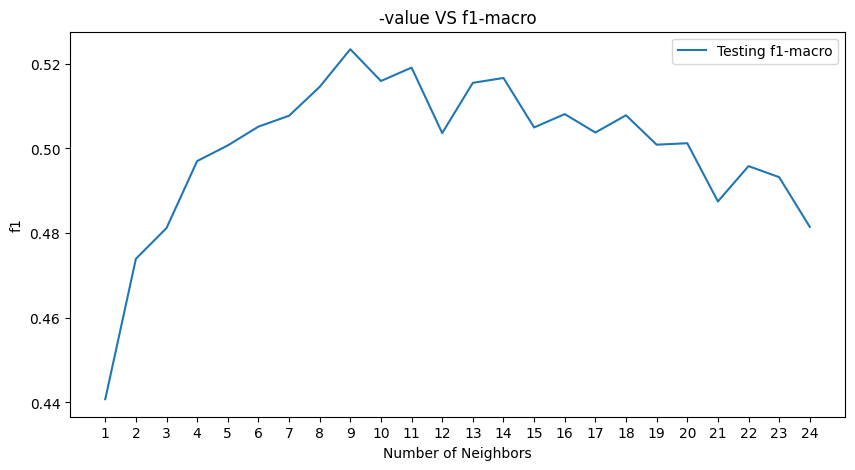

Best f1 is 0.5234228475981763 with K = 9


In [ ]:
# Model complexity
neig = np.arange(1, 25)
test_f1 = []

# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(embeddings_requests_e5_train, train["intent"])
    # Predict with knn
    prediction = knn.predict(embeddings_requests_e5_test)
    # test f1
    test_f1.append(f1_score(test["intent"], prediction, average='macro'))

# Plot
plt.figure(figsize=[10, 5])
plt.plot(neig, test_f1, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best f1 is {} with K = {}".format(np.max(test_f1), 1+test_f1.index(np.max(test_f1))))

Let's train the KNN classifier:

In [ ]:
K = 9  # Number of neighbors

# KNN-model
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
knn.fit(embeddings_requests_e5_train, train["intent"])

KNeighborsClassifier(metric='cosine', n_neighbors=9)

In [ ]:
prediction = knn.predict(embeddings_requests_e5_test)
f1_macro = f1_score(test["intent"], prediction, average='macro')  # f1-macro
print(f'With KNN (K={K}) f1-macro is: ', f1_macro)
print(f'With KNN (K={K}) accuracy is: ', knn.score(embeddings_requests_e5_test, test["intent"])) # accuracy

With KNN (K=9) f1-macro is:  0.5234228475981763
With KNN (K=9) accuracy is:  0.6277495769881557


Let's visualize the clusters of embeddings:

In [ ]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    A function for visualizing the results of t-SNE
        :param data: features
        :param n_iter: the number of iterations for gradient descent,
            could be beneficial to increase to obtain better results
        :param perplexity: the number of neighbors
        :param color: np.array[n_samples] with variable,
            that we want to use to color our observations
        :return tsne_emb: np.array[n_samples, 2] - the results of t-SNE
    """

    # Let's start with PCA, as it provides a good initial approximation for t-SNE
    # This will allow the algorithm to converge faster
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)


    # Let's run t-SNE, it will give us 2 numbers for each object,
    # which we can to draw
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=int(os.environ.get('PYTHONHASHSEED')))
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # We will also return the results of t-SNE
    return tsne_embedding

<ipython-input-40-2cb600546557>:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


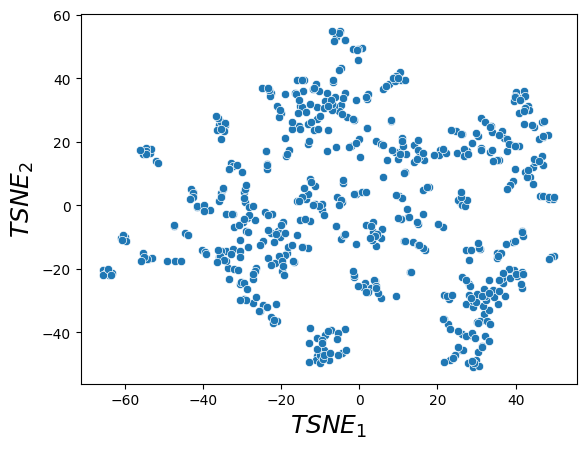

In [ ]:
tsne_test_requests_e5 = plot_tsne(embeddings_requests_e5_test,
                                  perplexity=K);

Let's color-code the predicted and ground truth intents differently:

In [ ]:
# Encoding text labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents_name)

# Color dictionary for labels
color_dict = {intents_name[i]: encoded_labels[i] for i in range(len(encoded_labels))}

# Creating a t-SNE plot for the first graph
trace1 = go.Scatter(x=tsne_test_requests_e5[:, 0],
                    y=tsne_test_requests_e5[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in prediction], colorscale='Jet', opacity=1),
                    text=prediction,
                    showlegend=False)

# Creating a t-SNE plot for the second graph
trace2 = go.Scatter(x=tsne_test_requests_e5[:, 0],
                    y=tsne_test_requests_e5[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in test["intent"]], colorscale='Jet', opacity=1),
                    text=test["intent"],
                    showlegend=False)

# Layout adjustments
layout1 = go.Layout(width=100, height=100)
layout2 = go.Layout(width=100, height=100)

# Creating figure for each graph
fig1 = go.Figure(data=[trace1], layout=layout1)
fig2 = go.Figure(data=[trace2], layout=layout2)

# Setting up subplot grid
fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Ground Truth"))

# Adding plots to a grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.show()

### bge-m3

#### Dataset generation

##### for classification evaluator

As loss function, we use OnlineConstrativeLoss. It reduces the distance between positive pairs, i.e., it pulls the embeddings of positive pairs closer together. For negative pairs, it pushes them further apart.

In [ ]:
def generate_positive_negative_pairs(dataset):
    # Grouping texts by classes
    grouped_texts = dataset.groupby('intent')['request'].apply(list)

    positive_pairs = []
    negative_pairs = []

    # Generating positive pairs for each class
    for intent, texts in grouped_texts.items():
        # Generating all possible combinations of texts
        positive_pairs.extend(combinations(texts, 2))

    # Generating negative pairs
    intents = grouped_texts.index.tolist()
    for i, intent_a in enumerate(intents):
        for j, intent_b in enumerate(intents):
            if i != j:  # Excluding pairs from the same class
                texts_a = grouped_texts[intent_a]
                texts_b = grouped_texts[intent_b]
                for text_a in texts_a:
                    for text_b in texts_b:
                        negative_pairs.append((text_a, text_b))

    return positive_pairs, negative_pairs

In [ ]:
# Generating positive and negative pairs of texts
positive_pairs, negative_pairs = generate_positive_negative_pairs(train_pruned)
print(f"Позитивных пар: {len(positive_pairs)}\nНегативных пар: {len(negative_pairs)}")

Позитивных пар: 6545
Негативных пар: 2431442


In [ ]:
# Duplicate check
#print(len(set(positive_pairs)), len(set(negative_pairs)))

In [ ]:
# Creating a DataFrame for positive pairs
positive_df = pd.DataFrame(positive_pairs, columns=['request1', 'request2'])

# Creating a DataFrame for negative pairs
negative_df = pd.DataFrame(negative_pairs, columns=['request1', 'request2'])
negative_df = negative_df.sample(n=len(positive_df), random_state=int(os.environ.get('PYTHONHASHSEED')))

# Adding the 'is_positive' column and assigning values
positive_df['is_positive'] = 1
negative_df['is_positive'] = 0

# Concatenating DataFrames for positive and negative pairs
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Let's create a dictionary of all unique requests using a dictionary generator
request_dict = {i + 1: request for i, request in enumerate(train_pruned['request'].unique())}

# Generating values for the 'rid1' and 'rid2' columns
combined_df['rid1'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request1']]
combined_df['rid2'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request2']]

# Reordering columns in the desired order
combined_df = combined_df[['rid1', 'rid2', 'request1', 'request2', 'is_positive']]

display(combined_df)

rid1  rid2                                           request1  \
0         1     2  в том году я покупал осаго за сейчас с одной а...   
1         1     3  в том году я покупал осаго за сейчас с одной а...   
2         1     4  в том году я покупал осаго за сейчас с одной а...   
3         1     5  в том году я покупал осаго за сейчас с одной а...   
4         1     6  в том году я покупал осаго за сейчас с одной а...   
...     ...   ...                                                ...   
13085   854   492                          позвоните по поводу каско   
13086   647  1392  ввел все данные правильно ну мне пишет то что ...   
13087   735   327  название организации в которой я работаю не вы...   
13088   577   444  есть сомнение по поводу заполнения мощности в ...   
13089  1239   370      как вписать еще одного водителя в полис осаго   

                                                request2  is_positive  
0      что изменилось с прошлого года в осаго продлен...            1  
1      почему в разное время цена полиса разная от од...            1  
2      почему стоимость осаго в приложении не актуаль...            1  
3      почему при оформлении полиса у меня резко меня...            1  
4                                     почему цены скачут            1  
...                                                  ...          ...  
13085  я оплатила полюс осаго 2 часа назад обещали ег...            0  
13086  почему я пишу адрес а сайт пишет что он не кор...            0  
13087  не могу найти подходящий тип страхования в рам...            0  
13088            оформил осаго в приложении не появилось            0  
13089                              как мне удалить карту            0  

[13090 rows x 5 columns]

In [ ]:
#combined_df.to_csv('combined_pairs.csv', index=False, encoding='utf-8')

##### for Duplicate Questions Information Retrieval evaluator

In [ ]:
ir_relevant_requests = {}  # Mapping of relevant request for a given request
rids = []  # request2 ids for filtering

for index, row in combined_df[combined_df['is_positive'] == 1].sort_values(by='rid1').iterrows():
  if row["rid2"] in rids:
    continue
  else:
    ir_relevant_requests[row["rid1"]] = ir_relevant_requests.get(row["rid1"], []) + [row["rid2"]]
    rids.append(row["rid2"])

In [ ]:
ir_relevant_requests = dict(sorted(ir_relevant_requests.items(), key=operator.itemgetter(0)))
ir_relevant_requests

{1: [4, 5, 10, 3, 2, 9, 7, 6, 8],
 11: [17, 14, 15, 16, 18, 19, 20, 13, 12],
 21: [25, 22, 28, 27, 23, 26, 24],
 29: [31, 33, 35, 30, 37, 38, 36, 34, 32],
 39: [47, 43, 44, 46, 45, 40, 48, 42, 41],
 49: [52, 54, 51, 50, 56, 57, 55, 53, 58],
 59: [64, 65, 60, 67, 68, 66, 63, 62, 61],
 69: [70, 71],
 72: [74, 75, 76, 73, 77, 78, 79, 81, 80],
 82: [91, 85, 90, 87, 86, 88, 89, 84, 83],
 92: [101, 98, 97, 93, 95, 94, 96, 99, 100],
 102: [107, 111, 108, 109, 110, 105, 104, 103, 106],
 112: [116, 119, 118, 117, 114, 115, 113, 121, 120],
 122: [124, 125, 123, 130, 131, 128, 129, 127, 126],
 132: [141, 138, 139, 136, 135, 137, 133, 134, 140],
 142: [147, 145, 146, 143, 144, 149, 151, 148, 150],
 152: [156, 155, 154, 159, 158, 160, 161, 157, 153],
 163: [166, 171, 164, 165, 172, 169, 168, 167, 170],
 173: [182, 179, 178, 181, 177, 174, 175, 176, 180],
 183: [190, 192, 189, 186, 185, 188, 187, 191, 184],
 193: [196, 195, 194, 197, 198],
 199: [202, 204, 205, 206, 207, 208, 203, 200, 201],
 209: [

In [ ]:
request_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
all_pair_requests_list = rids.copy()
all_pair_requests_list.extend(list(ir_relevant_requests.keys()))

In [ ]:
# All requests which have a pair
all_pair_requests_dict = {key: request_dict.get(key) for key in sorted(all_pair_requests_list)}
all_pair_requests_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
# Our requests1 (rid1 => request1)
ir_requests = {key: value for key, value in all_pair_requests_dict.items() if key in list(ir_relevant_requests.keys())}
ir_requests

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 21: 'как добавить ещё один страховой полис осаго помимо того что есть уже',
 29: 'не могу ввести данные иностранного водительского удостоверения',
 39: 'я бы хотел оформить осаго под такси ',
 49: 'я хочу застраховать сына 17 лет на период тренировок и игр в хоккейном клубе',
 59: 'мне нужен полис без гос номеров',
 69: 'оценочная стоимость квартиры',
 72: 'rакова вероятность одобрения кредита с плохой историей',
 82: 'как узнать есть ли на мне микрозаймы',
 92: 'на вашем сайте как узнать остаток долга по номеру кредитного договора в альфа банке',
 102: 'как узнать где был взят займ',
 112: 'как улучшить рейтинг',
 122: 'как обновить кр рейтинг а то остановился в том году',
 132: 'в какое время суток обычно происходят обновления кредитных рейтингов',
 142: 'я оставила заявку на кредит когда будет ответ ',
 152

In [ ]:
# Our requests2 (rid2 => request2)
ir_corpus_list = [x for x in list(all_pair_requests_dict.keys()) if x not in list(ir_relevant_requests.keys())]
ir_corpus = {key: value for key, value in all_pair_requests_dict.items() if key in ir_corpus_list}
ir_corpus

{2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'мне нужно квартира жизнь титул',
 16: 'там есть пункт титульное страхование как это добавить у вас на сайте',
 17: ' подскажите входить ли в мою страховку страховка титула',
 18: 



---



#### bge-m3 training

In [ ]:
import wandb
from google.colab import userdata

wandb_key = userdata.get("wandb")
wandb.login(key=wandb_key, anonymous="never")

wandb.init(
    project="intents_classifier",
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mikhail-repkin90. Use `wandb login --relogin` to force relogin


Since sentence-transformers still doesn't allow for proper logger integration, let's rewrite the code slightly and add loss logging to wandb

In [ ]:
class CustomSentenceTransformer(SentenceTransformer):
    def fit(
        self,
        train_objectives: Iterable[Tuple[DataLoader, nn.Module]],
        evaluator: SentenceEvaluator = None,
        epochs: int = 1,
        steps_per_epoch=None,
        scheduler: str = "WarmupLinear",
        warmup_steps: int = 10000,
        optimizer_class: Type[Optimizer] = torch.optim.AdamW,
        optimizer_params: Dict[str, object] = {"lr": 2e-5},
        weight_decay: float = 0.01,
        evaluation_steps: int = 0,
        output_path: str = None,
        save_best_model: bool = True,
        max_grad_norm: float = 1,
        use_amp: bool = False,
        callback: Callable[[float, int, int], None] = None,
        show_progress_bar: bool = True,
        checkpoint_path: str = None,
        checkpoint_save_steps: int = 500,
        checkpoint_save_total_limit: int = 0,
    ):

        ##Add info to model card
        # info_loss_functions = "\n".join(["- {} with {} training examples".format(str(loss), len(dataloader)) for dataloader, loss in train_objectives])
        info_loss_functions = []
        for dataloader, loss in train_objectives:
            info_loss_functions.extend(
                ModelCardTemplate.get_train_objective_info(dataloader, loss)
            )
        info_loss_functions = "\n\n".join([text for text in info_loss_functions])

        info_fit_parameters = json.dumps(
            {
                "evaluator": fullname(evaluator),
                "epochs": epochs,
                "steps_per_epoch": steps_per_epoch,
                "scheduler": scheduler,
                "warmup_steps": warmup_steps,
                "optimizer_class": str(optimizer_class),
                "optimizer_params": optimizer_params,
                "weight_decay": weight_decay,
                "evaluation_steps": evaluation_steps,
                "max_grad_norm": max_grad_norm,
            },
            indent=4,
            sort_keys=True,
        )
        self._model_card_text = None
        self._model_card_vars["{TRAINING_SECTION}"] = (
            ModelCardTemplate.__TRAINING_SECTION__.replace(
                "{LOSS_FUNCTIONS}", info_loss_functions
            ).replace("{FIT_PARAMETERS}", info_fit_parameters)
        )

        if use_amp:
            if is_torch_npu_available():
                scaler = torch.npu.amp.GradScaler()
            else:
                scaler = torch.cuda.amp.GradScaler()
        self.to(self.device)

        dataloaders = [dataloader for dataloader, _ in train_objectives]

        # Use smart batching
        for dataloader in dataloaders:
            dataloader.collate_fn = self.smart_batching_collate

        loss_models = [loss for _, loss in train_objectives]
        for loss_model in loss_models:
            loss_model.to(self.device)

        self.best_score = -9999999

        if steps_per_epoch is None or steps_per_epoch == 0:
            steps_per_epoch = min([len(dataloader) for dataloader in dataloaders])

        num_train_steps = int(steps_per_epoch * epochs)

        # Prepare optimizers
        optimizers = []
        schedulers = []
        for loss_model in loss_models:
            param_optimizer = list(loss_model.named_parameters())

            no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
            optimizer_grouped_parameters = [
                {
                    "params": [
                        p
                        for n, p in param_optimizer
                        if not any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": weight_decay,
                },
                {
                    "params": [
                        p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": 0.0,
                },
            ]

            optimizer = optimizer_class(
                optimizer_grouped_parameters, **optimizer_params
            )
            scheduler_obj = self._get_scheduler(
                optimizer,
                scheduler=scheduler,
                warmup_steps=warmup_steps,
                t_total=num_train_steps,
            )

            optimizers.append(optimizer)
            schedulers.append(scheduler_obj)

        global_step = 0
        data_iterators = [iter(dataloader) for dataloader in dataloaders]

        num_train_objectives = len(train_objectives)

        skip_scheduler = False
        for epoch in trange(epochs, desc="Epoch", disable=not show_progress_bar):
            training_steps = 0

            for loss_model in loss_models:
                loss_model.zero_grad()
                loss_model.train()

            for _ in trange(
                steps_per_epoch,
                desc="Iteration",
                smoothing=0.05,
                disable=not show_progress_bar,
            ):
                for train_idx in range(num_train_objectives):
                    loss_model = loss_models[train_idx]
                    optimizer = optimizers[train_idx]
                    scheduler = schedulers[train_idx]
                    data_iterator = data_iterators[train_idx]

                    try:
                        data = next(data_iterator)
                    except StopIteration:
                        data_iterator = iter(dataloaders[train_idx])
                        data_iterators[train_idx] = data_iterator
                        data = next(data_iterator)

                    features, labels = data
                    labels = labels.to(self.device)
                    features = list(
                        map(lambda batch: batch_to_device(batch, self.device), features)
                    )

                    if use_amp:
                        with torch.autocast(device_type=self.device.type):
                            loss_value = loss_model(features, labels)

                        scale_before_step = scaler.get_scale()
                        scaler.scale(loss_value).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        scaler.step(optimizer)
                        scaler.update()

                        skip_scheduler = scaler.get_scale() != scale_before_step
                    else:
                        loss_value = loss_model(features, labels)
                        wandb.log(
                            {f"train_{loss_model.__class__.__name__}": loss_value}
                        )
                        loss_value.backward()
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        optimizer.step()

                    optimizer.zero_grad()

                    if not skip_scheduler:
                        scheduler.step()

                training_steps += 1
                global_step += 1

                if evaluation_steps > 0 and training_steps % evaluation_steps == 0:
                    self._eval_during_training(
                        evaluator,
                        output_path,
                        save_best_model,
                        epoch,
                        training_steps,
                        callback,
                    )

                    for loss_model in loss_models:
                        loss_model.zero_grad()
                        loss_model.train()

                if (
                    checkpoint_path is not None
                    and checkpoint_save_steps is not None
                    and checkpoint_save_steps > 0
                    and global_step % checkpoint_save_steps == 0
                ):
                    self._save_checkpoint(
                        checkpoint_path, checkpoint_save_total_limit, global_step
                    )

            self._eval_during_training(
                evaluator, output_path, save_best_model, epoch, -1, callback
            )

        if (
            evaluator is None and output_path is not None
        ):  # No evaluator, but output path: save final model version
            self.save(output_path)

        if checkpoint_path is not None:
            self._save_checkpoint(
                checkpoint_path, checkpoint_save_total_limit, global_step
            )

In [ ]:
model = CustomSentenceTransformer('BAAI/bge-m3')
num_epochs = 10
train_batch_size = 16

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
# As distance metric, we use cosine distance (cosine_distance = 1-cosine_similarity)
distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE

# Negative pairs should have a distance of at least 0.5
margin = 0.5

model_save_path = "output/training_OnlineConstrativeLoss/bge-m3_1_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs(model_save_path, exist_ok=True)

In [ ]:
######### Read train data  ##########
# Read train data
train_samples = []
for index, row in combined_df.iterrows():
    sample = InputExample(texts=[row["request1"], row["request2"]], label=int(row["is_positive"]))
    train_samples.append(sample)

In [ ]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)

In [ ]:
################### Development  Evaluators ##################
# We add 2 evaluators, that evaluate the model on Duplicate Questions pair classification,
# and Duplicate Questions Information Retrieval

evaluators = []

###### Classification ######
# Given (quesiton1, question2), is this a duplicate or not?
# The evaluator will compute the embeddings for both questions and then compute
# a cosine similarity. If the similarity is above a threshold, we have a duplicate.
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []
for index, row in combined_df.iterrows():
    dev_sentences1.append(row["request1"])
    dev_sentences2.append(row["request2"])
    dev_labels.append(int(row["is_positive"]))

binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, dev_sentences2, dev_labels)
evaluators.append(binary_acc_evaluator)

###### Duplicate Questions Information Retrieval ######
# Given a question and a large corpus of thousands questions, find the most relevant (i.e. duplicate) question
# in that corpus.

# Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR metrices.
ir_evaluator = evaluation.InformationRetrievalEvaluator(ir_requests, ir_corpus, ir_relevant_requests)
evaluators.append(ir_evaluator)

# Create a SequentialEvaluator. This SequentialEvaluator runs all evaluators in a sequential order.
# We optimize the model with respect to the score from the last evaluator (scores[-1])
seq_evaluator = evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1])

In [ ]:
# Evaluate model without training
seq_evaluator(model, epoch=0, steps=0, output_path=model_save_path)

0.4006564291889621

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=seq_evaluator,
    epochs=num_epochs,
    warmup_steps=200,
    output_path=model_save_path,
    show_progress_bar=True,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

In [ ]:
model.save("bge-m3/OnlineConstrativeLoss/")

Let's generate embeddings from the dataset:

In [ ]:
embeddings_requests_bge_train = model.encode(list(train["request"]), convert_to_tensor=True).to("cpu")
embeddings_requests_bge_test = model.encode(list(test["request"]), convert_to_tensor=True).to("cpu")

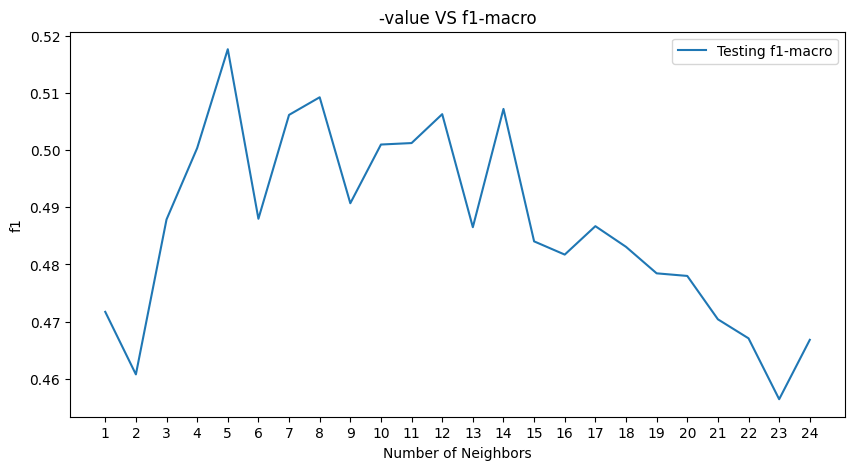

Best f1 is 0.5176498330108552 with K = 5


In [ ]:
# Model complexity
neig = np.arange(1, 25)
test_f1 = []

# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(embeddings_requests_bge_train, train["intent"])
    # Predict with knn
    prediction = knn.predict(embeddings_requests_bge_test)
    # test f1
    test_f1.append(f1_score(test["intent"], prediction, average='macro'))

# Plot
plt.figure(figsize=[10, 5])
plt.plot(neig, test_f1, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best f1 is {} with K = {}".format(np.max(test_f1), 1+test_f1.index(np.max(test_f1))))

Let's train the KNN classifier:

In [ ]:
K = 5  # Number of neighbors

# KNN-model
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
knn.fit(embeddings_requests_bge_train, train["intent"])

KNeighborsClassifier(metric='cosine')

In [ ]:
prediction = knn.predict(embeddings_requests_bge_test)
f1_macro = f1_score(test["intent"], prediction, average='macro')  # f1-macro
print(f'With KNN (K={K}) f1-macro is: ', f1_macro)
print(f'With KNN (K={K}) accuracy is: ', knn.score(embeddings_requests_bge_test, test["intent"])) # accuracy

With KNN (K=5) f1-macro is:  0.5176498330108552
With KNN (K=5) accuracy is:  0.5972927241962775


Let's visualize the clusters of embeddings:

In [ ]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    A function for visualizing the results of t-SNE
        :param data: features
        :param n_iter: the number of iterations for gradient descent,
            could be beneficial to increase to obtain better results
        :param perplexity: the number of neighbors
        :param color: np.array[n_samples] with variable,
            that we want to use to color our observations
        :return tsne_emb: np.array[n_samples, 2] - the results of t-SNE
    """

    # Let's start with PCA, as it provides a good initial approximation for t-SNE
    # This will allow the algorithm to converge faster
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)


    # Let's run t-SNE, it will give us 2 numbers for each object,
    # which we can to draw
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=int(os.environ.get('PYTHONHASHSEED')))
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # We will also return the results of t-SNE
    return tsne_embedding

<ipython-input-48-2cb600546557>:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


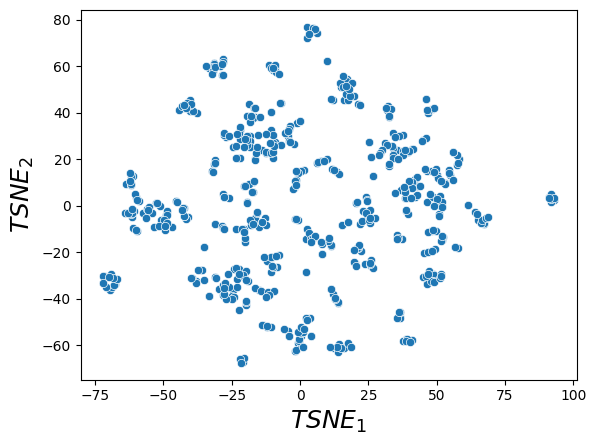

In [ ]:
tsne_test_requests_bge = plot_tsne(embeddings_requests_bge_test,
                                  perplexity=K);

Let's color-code the predicted and ground truth intents differently:

In [ ]:
# Encoding text labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents_name)

# Color dictionary for labels
color_dict = {intents_name[i]: encoded_labels[i] for i in range(len(encoded_labels))}

# Creating a t-SNE plot for the first graph
trace1 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in prediction], colorscale='Jet', opacity=1),
                    text=prediction,
                    showlegend=False)

# Creating a t-SNE plot for the second graph
trace2 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in test["intent"]], colorscale='Jet', opacity=1),
                    text=test["intent"],
                    showlegend=False)

# Layout adjustments
layout1 = go.Layout(width=100, height=100)
layout2 = go.Layout(width=100, height=100)

# Creating figure for each graph
fig1 = go.Figure(data=[trace1], layout=layout1)
fig2 = go.Figure(data=[trace2], layout=layout2)

# Setting up subplot grid
fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Ground Truth"))

# Adding plots to a grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.show()

# 3 Fine-tuning sentence encoder (using SentenceTransformer) with MultipleNegativesRankingLoss

### m-e5-large

#### Dataset generation

##### for classification evaluator

In [ ]:
def generate_positive_negative_pairs(dataset):
    """
    Генерирует позитивные и негативные пары текстов на основе размеченного датасета.

    Аргументы:
    dataset -- DataFrame с размеченными данными, содержащий столбцы 'request' (тексты) и 'intent' (классы).

    Возвращает:
    positive_pairs -- список позитивных пар текстов
    negative_pairs -- список негативных пар текстов
    """

    # Группируем тексты по классам
    grouped_texts = dataset.groupby('intent')['request'].apply(list)

    positive_pairs = []
    negative_pairs = []

    # Генерируем позитивные пары для каждого класса
    for intent, texts in grouped_texts.items():
        # Генерируем все возможные комбинации текстов
        positive_pairs.extend(combinations(texts, 2))

    # Генерируем негативные пары
    intents = grouped_texts.index.tolist()
    for i, intent_a in enumerate(intents):
        for j, intent_b in enumerate(intents):
            if i != j:  # Исключаем пары из одного класса
                texts_a = grouped_texts[intent_a]
                texts_b = grouped_texts[intent_b]
                for text_a in texts_a:
                    for text_b in texts_b:
                        negative_pairs.append((text_a, text_b))

    return positive_pairs, negative_pairs

In [ ]:
# Генерация позитивных и негативных пар текстов
positive_pairs, negative_pairs = generate_positive_negative_pairs(train_pruned)
print(f"Позитивных пар: {len(positive_pairs)}\nНегативных пар: {len(negative_pairs)}")

Позитивных пар: 6545
Негативных пар: 2431442


In [ ]:
# Создаем DataFrame для позитивных пар
positive_df = pd.DataFrame(positive_pairs, columns=['request1', 'request2'])

# Создаем DataFrame для негативных пар
negative_df = pd.DataFrame(negative_pairs, columns=['request1', 'request2'])
negative_df = negative_df.sample(n=len(positive_df), random_state=int(os.environ.get('PYTHONHASHSEED')))

# Добавляем столбец is_positive и присваиваем значения
positive_df['is_positive'] = 1
negative_df['is_positive'] = 0

# Объединяем DataFrame для позитивных и негативных пар
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Сформируем словарь всех уникальных риквестов с помощью генератора словаря
request_dict = {i + 1: request for i, request in enumerate(train_pruned['request'].unique())}

# Генерируем значения для столбцов rid1 и rid2
combined_df['rid1'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request1']]
combined_df['rid2'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request2']]

# Переупорядочиваем столбцы в нужном порядке
combined_df = combined_df[['rid1', 'rid2', 'request1', 'request2', 'is_positive']]

# Выводим результаты
display(combined_df)

rid1  rid2                                           request1  \
0         1     2  в том году я покупал осаго за сейчас с одной а...   
1         1     3  в том году я покупал осаго за сейчас с одной а...   
2         1     4  в том году я покупал осаго за сейчас с одной а...   
3         1     5  в том году я покупал осаго за сейчас с одной а...   
4         1     6  в том году я покупал осаго за сейчас с одной а...   
...     ...   ...                                                ...   
13085   854   492                          позвоните по поводу каско   
13086   647  1392  ввел все данные правильно ну мне пишет то что ...   
13087   735   327  название организации в которой я работаю не вы...   
13088   577   444  есть сомнение по поводу заполнения мощности в ...   
13089  1239   370      как вписать еще одного водителя в полис осаго   

                                                request2  is_positive  
0      что изменилось с прошлого года в осаго продлен...            1  
1      почему в разное время цена полиса разная от од...            1  
2      почему стоимость осаго в приложении не актуаль...            1  
3      почему при оформлении полиса у меня резко меня...            1  
4                                     почему цены скачут            1  
...                                                  ...          ...  
13085  я оплатила полюс осаго 2 часа назад обещали ег...            0  
13086  почему я пишу адрес а сайт пишет что он не кор...            0  
13087  не могу найти подходящий тип страхования в рам...            0  
13088            оформил осаго в приложении не появилось            0  
13089                              как мне удалить карту            0  

[13090 rows x 5 columns]

In [ ]:
#combined_df.to_csv('combined_pairs.csv', index=False, encoding='utf-8')

##### for Duplicate Questions Information Retrieval evaluator

In [ ]:
ir_relevant_requests = {}  # Mapping of relevant request for a given request
rids = []  # request2 ids for filtering

for index, row in combined_df[combined_df['is_positive'] == 1].sort_values(by='rid1').iterrows():
  if row["rid2"] in rids:
    continue
  else:
    ir_relevant_requests[row["rid1"]] = ir_relevant_requests.get(row["rid1"], []) + [row["rid2"]]
    rids.append(row["rid2"])

In [ ]:
ir_relevant_requests = dict(sorted(ir_relevant_requests.items(), key=operator.itemgetter(0)))
ir_relevant_requests

{1: [4, 5, 10, 3, 2, 9, 7, 6, 8],
 11: [17, 14, 15, 16, 18, 19, 20, 13, 12],
 21: [25, 22, 28, 27, 23, 26, 24],
 29: [31, 33, 35, 30, 37, 38, 36, 34, 32],
 39: [47, 43, 44, 46, 45, 40, 48, 42, 41],
 49: [52, 54, 51, 50, 56, 57, 55, 53, 58],
 59: [64, 65, 60, 67, 68, 66, 63, 62, 61],
 69: [70, 71],
 72: [74, 75, 76, 73, 77, 78, 79, 81, 80],
 82: [91, 85, 90, 87, 86, 88, 89, 84, 83],
 92: [101, 98, 97, 93, 95, 94, 96, 99, 100],
 102: [107, 111, 108, 109, 110, 105, 104, 103, 106],
 112: [116, 119, 118, 117, 114, 115, 113, 121, 120],
 122: [124, 125, 123, 130, 131, 128, 129, 127, 126],
 132: [141, 138, 139, 136, 135, 137, 133, 134, 140],
 142: [147, 145, 146, 143, 144, 149, 151, 148, 150],
 152: [156, 155, 154, 159, 158, 160, 161, 157, 153],
 163: [166, 171, 164, 165, 172, 169, 168, 167, 170],
 173: [182, 179, 178, 181, 177, 174, 175, 176, 180],
 183: [190, 192, 189, 186, 185, 188, 187, 191, 184],
 193: [196, 195, 194, 197, 198],
 199: [202, 204, 205, 206, 207, 208, 203, 200, 201],
 209: [

In [ ]:
request_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
all_pair_requests_list = rids.copy()
all_pair_requests_list.extend(list(ir_relevant_requests.keys()))

In [ ]:
# All requests which have a pair
all_pair_requests_dict = {key: request_dict.get(key) for key in sorted(all_pair_requests_list)}
all_pair_requests_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
# Our requests1 (rid1 => request1)
ir_requests = {key: value for key, value in all_pair_requests_dict.items() if key in list(ir_relevant_requests.keys())}
ir_requests

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 21: 'как добавить ещё один страховой полис осаго помимо того что есть уже',
 29: 'не могу ввести данные иностранного водительского удостоверения',
 39: 'я бы хотел оформить осаго под такси ',
 49: 'я хочу застраховать сына 17 лет на период тренировок и игр в хоккейном клубе',
 59: 'мне нужен полис без гос номеров',
 69: 'оценочная стоимость квартиры',
 72: 'rакова вероятность одобрения кредита с плохой историей',
 82: 'как узнать есть ли на мне микрозаймы',
 92: 'на вашем сайте как узнать остаток долга по номеру кредитного договора в альфа банке',
 102: 'как узнать где был взят займ',
 112: 'как улучшить рейтинг',
 122: 'как обновить кр рейтинг а то остановился в том году',
 132: 'в какое время суток обычно происходят обновления кредитных рейтингов',
 142: 'я оставила заявку на кредит когда будет ответ ',
 152

In [ ]:
# Our requests2 (rid2 => request2)
ir_corpus_list = [x for x in list(all_pair_requests_dict.keys()) if x not in list(ir_relevant_requests.keys())]
ir_corpus = {key: value for key, value in all_pair_requests_dict.items() if key in ir_corpus_list}
ir_corpus

{2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'мне нужно квартира жизнь титул',
 16: 'там есть пункт титульное страхование как это добавить у вас на сайте',
 17: ' подскажите входить ли в мою страховку страховка титула',
 18: 



---



#### m-e5-large training

In [ ]:
import wandb
from google.colab import userdata

wandb_key = userdata.get("wandb")
wandb.login(key=wandb_key, anonymous="never")

wandb.init(
    project="intents_classifier",
)

wandb: Currently logged in as: mikhail-repkin90. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Since sentence-transformers still doesn't allow for proper logger integration, let's rewrite the code slightly and add loss logging to wandb

In [ ]:
class CustomSentenceTransformer(SentenceTransformer):
    def fit(
        self,
        train_objectives: Iterable[Tuple[DataLoader, nn.Module]],
        evaluator: SentenceEvaluator = None,
        epochs: int = 1,
        steps_per_epoch=None,
        scheduler: str = "WarmupLinear",
        warmup_steps: int = 10000,
        optimizer_class: Type[Optimizer] = torch.optim.AdamW,
        optimizer_params: Dict[str, object] = {"lr": 2e-5},
        weight_decay: float = 0.01,
        evaluation_steps: int = 0,
        output_path: str = None,
        save_best_model: bool = True,
        max_grad_norm: float = 1,
        use_amp: bool = False,
        callback: Callable[[float, int, int], None] = None,
        show_progress_bar: bool = True,
        checkpoint_path: str = None,
        checkpoint_save_steps: int = 500,
        checkpoint_save_total_limit: int = 0,
    ):

        ##Add info to model card
        # info_loss_functions = "\n".join(["- {} with {} training examples".format(str(loss), len(dataloader)) for dataloader, loss in train_objectives])
        info_loss_functions = []
        for dataloader, loss in train_objectives:
            info_loss_functions.extend(
                ModelCardTemplate.get_train_objective_info(dataloader, loss)
            )
        info_loss_functions = "\n\n".join([text for text in info_loss_functions])

        info_fit_parameters = json.dumps(
            {
                "evaluator": fullname(evaluator),
                "epochs": epochs,
                "steps_per_epoch": steps_per_epoch,
                "scheduler": scheduler,
                "warmup_steps": warmup_steps,
                "optimizer_class": str(optimizer_class),
                "optimizer_params": optimizer_params,
                "weight_decay": weight_decay,
                "evaluation_steps": evaluation_steps,
                "max_grad_norm": max_grad_norm,
            },
            indent=4,
            sort_keys=True,
        )
        self._model_card_text = None
        self._model_card_vars["{TRAINING_SECTION}"] = (
            ModelCardTemplate.__TRAINING_SECTION__.replace(
                "{LOSS_FUNCTIONS}", info_loss_functions
            ).replace("{FIT_PARAMETERS}", info_fit_parameters)
        )

        if use_amp:
            if is_torch_npu_available():
                scaler = torch.npu.amp.GradScaler()
            else:
                scaler = torch.cuda.amp.GradScaler()
        self.to(self.device)

        dataloaders = [dataloader for dataloader, _ in train_objectives]

        # Use smart batching
        for dataloader in dataloaders:
            dataloader.collate_fn = self.smart_batching_collate

        loss_models = [loss for _, loss in train_objectives]
        for loss_model in loss_models:
            loss_model.to(self.device)

        self.best_score = -9999999

        if steps_per_epoch is None or steps_per_epoch == 0:
            steps_per_epoch = min([len(dataloader) for dataloader in dataloaders])

        num_train_steps = int(steps_per_epoch * epochs)

        # Prepare optimizers
        optimizers = []
        schedulers = []
        for loss_model in loss_models:
            param_optimizer = list(loss_model.named_parameters())

            no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
            optimizer_grouped_parameters = [
                {
                    "params": [
                        p
                        for n, p in param_optimizer
                        if not any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": weight_decay,
                },
                {
                    "params": [
                        p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": 0.0,
                },
            ]

            optimizer = optimizer_class(
                optimizer_grouped_parameters, **optimizer_params
            )
            scheduler_obj = self._get_scheduler(
                optimizer,
                scheduler=scheduler,
                warmup_steps=warmup_steps,
                t_total=num_train_steps,
            )

            optimizers.append(optimizer)
            schedulers.append(scheduler_obj)

        global_step = 0
        data_iterators = [iter(dataloader) for dataloader in dataloaders]

        num_train_objectives = len(train_objectives)

        skip_scheduler = False
        for epoch in trange(epochs, desc="Epoch", disable=not show_progress_bar):
            training_steps = 0

            for loss_model in loss_models:
                loss_model.zero_grad()
                loss_model.train()

            for _ in trange(
                steps_per_epoch,
                desc="Iteration",
                smoothing=0.05,
                disable=not show_progress_bar,
            ):
                for train_idx in range(num_train_objectives):
                    loss_model = loss_models[train_idx]
                    optimizer = optimizers[train_idx]
                    scheduler = schedulers[train_idx]
                    data_iterator = data_iterators[train_idx]

                    try:
                        data = next(data_iterator)
                    except StopIteration:
                        data_iterator = iter(dataloaders[train_idx])
                        data_iterators[train_idx] = data_iterator
                        data = next(data_iterator)

                    features, labels = data
                    labels = labels.to(self.device)
                    features = list(
                        map(lambda batch: batch_to_device(batch, self.device), features)
                    )

                    if use_amp:
                        with torch.autocast(device_type=self.device.type):
                            loss_value = loss_model(features, labels)

                        scale_before_step = scaler.get_scale()
                        scaler.scale(loss_value).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        scaler.step(optimizer)
                        scaler.update()

                        skip_scheduler = scaler.get_scale() != scale_before_step
                    else:
                        loss_value = loss_model(features, labels)
                        wandb.log(
                            {f"train_{loss_model.__class__.__name__}": loss_value}
                        )
                        loss_value.backward()
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        optimizer.step()

                    optimizer.zero_grad()

                    if not skip_scheduler:
                        scheduler.step()

                training_steps += 1
                global_step += 1

                if evaluation_steps > 0 and training_steps % evaluation_steps == 0:
                    self._eval_during_training(
                        evaluator,
                        output_path,
                        save_best_model,
                        epoch,
                        training_steps,
                        callback,
                    )

                    for loss_model in loss_models:
                        loss_model.zero_grad()
                        loss_model.train()

                if (
                    checkpoint_path is not None
                    and checkpoint_save_steps is not None
                    and checkpoint_save_steps > 0
                    and global_step % checkpoint_save_steps == 0
                ):
                    self._save_checkpoint(
                        checkpoint_path, checkpoint_save_total_limit, global_step
                    )

            self._eval_during_training(
                evaluator, output_path, save_best_model, epoch, -1, callback
            )

        if (
            evaluator is None and output_path is not None
        ):  # No evaluator, but output path: save final model version
            self.save(output_path)

        if checkpoint_path is not None:
            self._save_checkpoint(
                checkpoint_path, checkpoint_save_total_limit, global_step
            )

MultipleNegativesRankingLoss is especially suitable for Information Retrieval / Semantic Search. A nice advantage of MultipleNegativesRankingLoss is that it only requires positive pairs, i.e., we only need examples of duplicate questions.

In [ ]:
model = CustomSentenceTransformer('intfloat/multilingual-e5-large')
num_epochs = 10
train_batch_size = 16

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model_save_path = "output/training_MultipleNegativesRankingLoss/m-e5-large_2_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(model_save_path, exist_ok=True)

In [ ]:
######### Read train data  ##########
# Grouping texts by classes.
grouped_texts = train_pruned.groupby('intent')['request'].apply(list)

positive_pairs = []
# Generating positive pairs for each class
for intent, texts in grouped_texts.items():
    # Generating all possible combinations of texts
    positive_pairs.extend(combinations(texts, 2))


train_samples = []
for row in positive_pairs:
    train_samples.append(
        InputExample(texts=[row[0], row[1]], label=1)
        )
    train_samples.append(
        InputExample(texts=[row[1], row[0]], label=1)
        )  # if A is a duplicate of B, then B is a duplicate of A

In [ ]:
# After reading the train_samples, we create a SentencesDataset and a DataLoader
train_dataset = SentencesDataset(train_samples, model=model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:
################### Development  Evaluators ##################
# We add 2 evaluators, that evaluate the model on Duplicate Questions pair classification,
# and Duplicate Questions Information Retrieval

evaluators = []

###### Classification ######
# Given (quesiton1, question2), is this a duplicate or not?
# The evaluator will compute the embeddings for both questions and then compute
# a cosine similarity. If the similarity is above a threshold, we have a duplicate.
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []
for index, row in combined_df.iterrows():
    dev_sentences1.append(row["request1"])
    dev_sentences2.append(row["request2"])
    dev_labels.append(int(row["is_positive"]))

binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, dev_sentences2, dev_labels)
evaluators.append(binary_acc_evaluator)

###### Duplicate Questions Information Retrieval ######
# Given a question and a large corpus of thousands questions, find the most relevant (i.e. duplicate) question
# in that corpus.

# Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR metrices.
ir_evaluator = evaluation.InformationRetrievalEvaluator(ir_requests, ir_corpus, ir_relevant_requests)
evaluators.append(ir_evaluator)

# Create a SequentialEvaluator. This SequentialEvaluator runs all evaluators in a sequential order.
# We optimize the model with respect to the score from the last evaluator (scores[-1])
seq_evaluator = evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1])

In [ ]:
# Evaluate model without training
seq_evaluator(model, epoch=0, steps=0, output_path=model_save_path)

0.33901006831711267

In [ ]:
# Call the fit method
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=seq_evaluator,
    epochs=num_epochs,
    warmup_steps=200,
    output_path=model_save_path,
    show_progress_bar=True
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

In [ ]:
model.save("m-e5-large/MultipleNegativesRankingLoss/")

Let's generate embeddings from the dataset:

In [ ]:
embeddings_requests_e5_train = model.encode(list(train["request"]), convert_to_tensor=True).to("cpu")
embeddings_requests_e5_test = model.encode(list(test["request"]), convert_to_tensor=True).to("cpu")

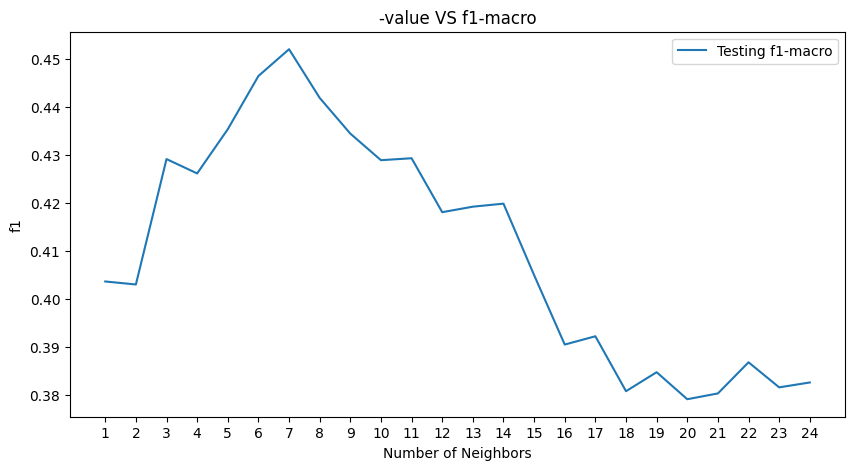

Best f1 is 0.4519943084496019 with K = 7


In [ ]:
# Model complexity
neig = np.arange(1, 25)
test_f1 = []

# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(embeddings_requests_e5_train, train["intent"])
    # Predict with knn
    prediction = knn.predict(embeddings_requests_e5_test)
    # test f1
    test_f1.append(f1_score(test["intent"], prediction, average='macro'))

# Plot
plt.figure(figsize=[10, 5])
plt.plot(neig, test_f1, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best f1 is {} with K = {}".format(np.max(test_f1), 1+test_f1.index(np.max(test_f1))))

Let's train the KNN classifier:

In [ ]:
K = 7  # Number of neighbors

# KNN-model
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
knn.fit(embeddings_requests_e5_train, train["intent"])

KNeighborsClassifier(metric='cosine', n_neighbors=7)

In [ ]:
prediction = knn.predict(embeddings_requests_e5_test)
f1_macro = f1_score(test["intent"], prediction, average='macro')  # f1-macro
print(f'With KNN (K={K}) f1-macro is: ', f1_macro)
print(f'With KNN (K={K}) accuracy is: ', knn.score(embeddings_requests_e5_test, test["intent"])) # accuracy

With KNN (K=7) f1-macro is:  0.4519943084496019
With KNN (K=7) accuracy is:  0.6175972927241963


Let's visualize the clusters of embeddings:

In [ ]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    A function for visualizing the results of t-SNE
        :param data: features
        :param n_iter: the number of iterations for gradient descent,
            could be beneficial to increase to obtain better results
        :param perplexity: the number of neighbors
        :param color: np.array[n_samples] with variable,
            that we want to use to color our observations
        :return tsne_emb: np.array[n_samples, 2] - the results of t-SNE
    """

    # Let's start with PCA, as it provides a good initial approximation for t-SNE
    # This will allow the algorithm to converge faster
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)


    # Let's run t-SNE, it will give us 2 numbers for each object,
    # which we can to draw
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=int(os.environ.get('PYTHONHASHSEED')))
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # We will also return the results of t-SNE
    return tsne_embedding

<ipython-input-40-2cb600546557>:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


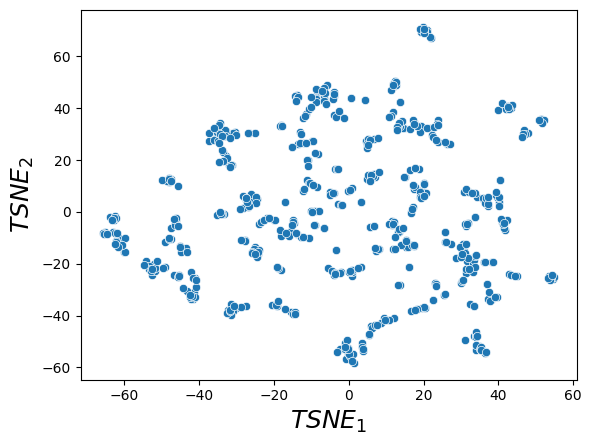

In [ ]:
tsne_test_requests_e5 = plot_tsne(embeddings_requests_e5_test,
                                  perplexity=K);

Let's color-code the predicted and ground truth intents differently:

In [ ]:
# Encoding text labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents_name)

# Color dictionary for labels
color_dict = {intents_name[i]: encoded_labels[i] for i in range(len(encoded_labels))}

# Creating a t-SNE plot for the first graph
trace1 = go.Scatter(x=tsne_test_requests_e5[:, 0],
                    y=tsne_test_requests_e5[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in prediction], colorscale='Jet', opacity=1),
                    text=prediction,
                    showlegend=False)

# Creating a t-SNE plot for the second graph
trace2 = go.Scatter(x=tsne_test_requests_e5[:, 0],
                    y=tsne_test_requests_e5[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in test["intent"]], colorscale='Jet', opacity=1),
                    text=test["intent"],
                    showlegend=False)

# Layout adjustments
layout1 = go.Layout(width=100, height=100)
layout2 = go.Layout(width=100, height=100)

# Creating figure for each graph
fig1 = go.Figure(data=[trace1], layout=layout1)
fig2 = go.Figure(data=[trace2], layout=layout2)

# Setting up subplot grid
fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Ground Truth"))

# Adding plots to a grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.show()

### bge-m3

#### Dataset generation

##### for classification evaluator

In [ ]:
def generate_positive_negative_pairs(dataset):
    """
    Генерирует позитивные и негативные пары текстов на основе размеченного датасета.

    Аргументы:
    dataset -- DataFrame с размеченными данными, содержащий столбцы 'request' (тексты) и 'intent' (классы).

    Возвращает:
    positive_pairs -- список позитивных пар текстов
    negative_pairs -- список негативных пар текстов
    """

    # Grouping texts by classes.
    grouped_texts = dataset.groupby('intent')['request'].apply(list)

    positive_pairs = []
    negative_pairs = []

    # Generating positive pairs for each class
    for intent, texts in grouped_texts.items():
        # Generating all possible combinations of texts
        positive_pairs.extend(combinations(texts, 2))

    # Generating negative pairs
    intents = grouped_texts.index.tolist()
    for i, intent_a in enumerate(intents):
        for j, intent_b in enumerate(intents):
            if i != j:  # Excluding pairs from the same class
                texts_a = grouped_texts[intent_a]
                texts_b = grouped_texts[intent_b]
                for text_a in texts_a:
                    for text_b in texts_b:
                        negative_pairs.append((text_a, text_b))

    return positive_pairs, negative_pairs

In [ ]:
# Generating positive and negative pairs of texts
positive_pairs, negative_pairs = generate_positive_negative_pairs(train_pruned)
print(f"Позитивных пар: {len(positive_pairs)}\nНегативных пар: {len(negative_pairs)}")

Позитивных пар: 6545
Негативных пар: 2431442


In [ ]:
# Creating a DataFrame for positive pairs
positive_df = pd.DataFrame(positive_pairs, columns=['request1', 'request2'])

# Creating a DataFrame for negative pairs
negative_df = pd.DataFrame(negative_pairs, columns=['request1', 'request2'])
negative_df = negative_df.sample(n=len(positive_df), random_state=int(os.environ.get('PYTHONHASHSEED')))

# Adding the 'is_positive' column and assigning values
positive_df['is_positive'] = 1
negative_df['is_positive'] = 0

# Concatenating DataFrames for positive and negative pairs
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Let's create a dictionary of all unique requests using a dictionary generator
request_dict = {i + 1: request for i, request in enumerate(train_pruned['request'].unique())}

# Generating values for the 'rid1' and 'rid2' columns
combined_df['rid1'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request1']]
combined_df['rid2'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request2']]

# Reordering columns in the desired order
combined_df = combined_df[['rid1', 'rid2', 'request1', 'request2', 'is_positive']]

display(combined_df)

rid1  rid2                                           request1  \
0         1     2  в том году я покупал осаго за сейчас с одной а...   
1         1     3  в том году я покупал осаго за сейчас с одной а...   
2         1     4  в том году я покупал осаго за сейчас с одной а...   
3         1     5  в том году я покупал осаго за сейчас с одной а...   
4         1     6  в том году я покупал осаго за сейчас с одной а...   
...     ...   ...                                                ...   
13085   854   492                          позвоните по поводу каско   
13086   647  1392  ввел все данные правильно ну мне пишет то что ...   
13087   735   327  название организации в которой я работаю не вы...   
13088   577   444  есть сомнение по поводу заполнения мощности в ...   
13089  1239   370      как вписать еще одного водителя в полис осаго   

                                                request2  is_positive  
0      что изменилось с прошлого года в осаго продлен...            1  
1      почему в разное время цена полиса разная от од...            1  
2      почему стоимость осаго в приложении не актуаль...            1  
3      почему при оформлении полиса у меня резко меня...            1  
4                                     почему цены скачут            1  
...                                                  ...          ...  
13085  я оплатила полюс осаго 2 часа назад обещали ег...            0  
13086  почему я пишу адрес а сайт пишет что он не кор...            0  
13087  не могу найти подходящий тип страхования в рам...            0  
13088            оформил осаго в приложении не появилось            0  
13089                              как мне удалить карту            0  

[13090 rows x 5 columns]

In [ ]:
#combined_df.to_csv('combined_pairs.csv', index=False, encoding='utf-8')

##### for Duplicate Questions Information Retrieval evaluator

In [ ]:
ir_relevant_requests = {}  # Mapping of relevant request for a given request
rids = []  # request2 ids for filtering

for index, row in combined_df[combined_df['is_positive'] == 1].sort_values(by='rid1').iterrows():
  if row["rid2"] in rids:
    continue
  else:
    ir_relevant_requests[row["rid1"]] = ir_relevant_requests.get(row["rid1"], []) + [row["rid2"]]
    rids.append(row["rid2"])

In [ ]:
ir_relevant_requests = dict(sorted(ir_relevant_requests.items(), key=operator.itemgetter(0)))
ir_relevant_requests

{1: [4, 5, 10, 3, 2, 9, 7, 6, 8],
 11: [17, 14, 15, 16, 18, 19, 20, 13, 12],
 21: [25, 22, 28, 27, 23, 26, 24],
 29: [31, 33, 35, 30, 37, 38, 36, 34, 32],
 39: [47, 43, 44, 46, 45, 40, 48, 42, 41],
 49: [52, 54, 51, 50, 56, 57, 55, 53, 58],
 59: [64, 65, 60, 67, 68, 66, 63, 62, 61],
 69: [70, 71],
 72: [74, 75, 76, 73, 77, 78, 79, 81, 80],
 82: [91, 85, 90, 87, 86, 88, 89, 84, 83],
 92: [101, 98, 97, 93, 95, 94, 96, 99, 100],
 102: [107, 111, 108, 109, 110, 105, 104, 103, 106],
 112: [116, 119, 118, 117, 114, 115, 113, 121, 120],
 122: [124, 125, 123, 130, 131, 128, 129, 127, 126],
 132: [141, 138, 139, 136, 135, 137, 133, 134, 140],
 142: [147, 145, 146, 143, 144, 149, 151, 148, 150],
 152: [156, 155, 154, 159, 158, 160, 161, 157, 153],
 163: [166, 171, 164, 165, 172, 169, 168, 167, 170],
 173: [182, 179, 178, 181, 177, 174, 175, 176, 180],
 183: [190, 192, 189, 186, 185, 188, 187, 191, 184],
 193: [196, 195, 194, 197, 198],
 199: [202, 204, 205, 206, 207, 208, 203, 200, 201],
 209: [

In [ ]:
request_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
all_pair_requests_list = rids.copy()
all_pair_requests_list.extend(list(ir_relevant_requests.keys()))

In [ ]:
# All requests which have a pair
all_pair_requests_dict = {key: request_dict.get(key) for key in sorted(all_pair_requests_list)}
all_pair_requests_dict

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'м

In [ ]:
# Our requests1 (rid1 => request1)
ir_requests = {key: value for key, value in all_pair_requests_dict.items() if key in list(ir_relevant_requests.keys())}
ir_requests

{1: 'в том году я покупал осаго за сейчас с одной аварией осаго стоит  как это вообще откуда такие суммы',
 11: 'можно ли застраховать ипотеку жизнь и титул для банка открытие',
 21: 'как добавить ещё один страховой полис осаго помимо того что есть уже',
 29: 'не могу ввести данные иностранного водительского удостоверения',
 39: 'я бы хотел оформить осаго под такси ',
 49: 'я хочу застраховать сына 17 лет на период тренировок и игр в хоккейном клубе',
 59: 'мне нужен полис без гос номеров',
 69: 'оценочная стоимость квартиры',
 72: 'rакова вероятность одобрения кредита с плохой историей',
 82: 'как узнать есть ли на мне микрозаймы',
 92: 'на вашем сайте как узнать остаток долга по номеру кредитного договора в альфа банке',
 102: 'как узнать где был взят займ',
 112: 'как улучшить рейтинг',
 122: 'как обновить кр рейтинг а то остановился в том году',
 132: 'в какое время суток обычно происходят обновления кредитных рейтингов',
 142: 'я оставила заявку на кредит когда будет ответ ',
 152

In [ ]:
# Our requests2 (rid2 => request2)
ir_corpus_list = [x for x in list(all_pair_requests_dict.keys()) if x not in list(ir_relevant_requests.keys())]
ir_corpus = {key: value for key, value in all_pair_requests_dict.items() if key in ir_corpus_list}
ir_corpus

{2: 'что изменилось с прошлого года в осаго продление страхования на тех же условиях дороже на две тысячи',
 3: 'почему в разное время цена полиса разная от одни и тех же компаний',
 4: 'почему стоимость осаго в приложении не актуальна и завышена',
 5: 'почему при оформлении полиса у меня резко меняется цена',
 6: 'почему цены скачут',
 7: 'подскажите пожалуйста почему у вас цена на сайте меньше чем у самих страховых компаний',
 8: 'в прошлом году делала страховку через ваш сайт в росгосстрахе за 8500а в этом году уже выдает 11700дтп не былопочему такая цена',
 9: 'че так дорого',
 10: 'почему полис осаго увеличился в цене',
 12: 'хотим застраховать титул и страховка жилья',
 13: 'меня интересует страхование объект титул где мне выгодно это сделать',
 14: 'могу ли я оформить титульную страховку онлайн',
 15: 'мне нужно квартира жизнь титул',
 16: 'там есть пункт титульное страхование как это добавить у вас на сайте',
 17: ' подскажите входить ли в мою страховку страховка титула',
 18: 



---



#### bge-m3 training

In [ ]:
import wandb
from google.colab import userdata

wandb_key = userdata.get("wandb")
wandb.login(key=wandb_key, anonymous="never")

wandb.init(
    project="intents_classifier",
)

wandb: Currently logged in as: mikhail-repkin90. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Since sentence-transformers still doesn't allow for proper logger integration, let's rewrite the code slightly and add loss logging to wandb

In [ ]:
class CustomSentenceTransformer(SentenceTransformer):
    def fit(
        self,
        train_objectives: Iterable[Tuple[DataLoader, nn.Module]],
        evaluator: SentenceEvaluator = None,
        epochs: int = 1,
        steps_per_epoch=None,
        scheduler: str = "WarmupLinear",
        warmup_steps: int = 10000,
        optimizer_class: Type[Optimizer] = torch.optim.AdamW,
        optimizer_params: Dict[str, object] = {"lr": 2e-5},
        weight_decay: float = 0.01,
        evaluation_steps: int = 0,
        output_path: str = None,
        save_best_model: bool = True,
        max_grad_norm: float = 1,
        use_amp: bool = False,
        callback: Callable[[float, int, int], None] = None,
        show_progress_bar: bool = True,
        checkpoint_path: str = None,
        checkpoint_save_steps: int = 500,
        checkpoint_save_total_limit: int = 0,
    ):

        ##Add info to model card
        # info_loss_functions = "\n".join(["- {} with {} training examples".format(str(loss), len(dataloader)) for dataloader, loss in train_objectives])
        info_loss_functions = []
        for dataloader, loss in train_objectives:
            info_loss_functions.extend(
                ModelCardTemplate.get_train_objective_info(dataloader, loss)
            )
        info_loss_functions = "\n\n".join([text for text in info_loss_functions])

        info_fit_parameters = json.dumps(
            {
                "evaluator": fullname(evaluator),
                "epochs": epochs,
                "steps_per_epoch": steps_per_epoch,
                "scheduler": scheduler,
                "warmup_steps": warmup_steps,
                "optimizer_class": str(optimizer_class),
                "optimizer_params": optimizer_params,
                "weight_decay": weight_decay,
                "evaluation_steps": evaluation_steps,
                "max_grad_norm": max_grad_norm,
            },
            indent=4,
            sort_keys=True,
        )
        self._model_card_text = None
        self._model_card_vars["{TRAINING_SECTION}"] = (
            ModelCardTemplate.__TRAINING_SECTION__.replace(
                "{LOSS_FUNCTIONS}", info_loss_functions
            ).replace("{FIT_PARAMETERS}", info_fit_parameters)
        )

        if use_amp:
            if is_torch_npu_available():
                scaler = torch.npu.amp.GradScaler()
            else:
                scaler = torch.cuda.amp.GradScaler()
        self.to(self.device)

        dataloaders = [dataloader for dataloader, _ in train_objectives]

        # Use smart batching
        for dataloader in dataloaders:
            dataloader.collate_fn = self.smart_batching_collate

        loss_models = [loss for _, loss in train_objectives]
        for loss_model in loss_models:
            loss_model.to(self.device)

        self.best_score = -9999999

        if steps_per_epoch is None or steps_per_epoch == 0:
            steps_per_epoch = min([len(dataloader) for dataloader in dataloaders])

        num_train_steps = int(steps_per_epoch * epochs)

        # Prepare optimizers
        optimizers = []
        schedulers = []
        for loss_model in loss_models:
            param_optimizer = list(loss_model.named_parameters())

            no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
            optimizer_grouped_parameters = [
                {
                    "params": [
                        p
                        for n, p in param_optimizer
                        if not any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": weight_decay,
                },
                {
                    "params": [
                        p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                    ],
                    "weight_decay": 0.0,
                },
            ]

            optimizer = optimizer_class(
                optimizer_grouped_parameters, **optimizer_params
            )
            scheduler_obj = self._get_scheduler(
                optimizer,
                scheduler=scheduler,
                warmup_steps=warmup_steps,
                t_total=num_train_steps,
            )

            optimizers.append(optimizer)
            schedulers.append(scheduler_obj)

        global_step = 0
        data_iterators = [iter(dataloader) for dataloader in dataloaders]

        num_train_objectives = len(train_objectives)

        skip_scheduler = False
        for epoch in trange(epochs, desc="Epoch", disable=not show_progress_bar):
            training_steps = 0

            for loss_model in loss_models:
                loss_model.zero_grad()
                loss_model.train()

            for _ in trange(
                steps_per_epoch,
                desc="Iteration",
                smoothing=0.05,
                disable=not show_progress_bar,
            ):
                for train_idx in range(num_train_objectives):
                    loss_model = loss_models[train_idx]
                    optimizer = optimizers[train_idx]
                    scheduler = schedulers[train_idx]
                    data_iterator = data_iterators[train_idx]

                    try:
                        data = next(data_iterator)
                    except StopIteration:
                        data_iterator = iter(dataloaders[train_idx])
                        data_iterators[train_idx] = data_iterator
                        data = next(data_iterator)

                    features, labels = data
                    labels = labels.to(self.device)
                    features = list(
                        map(lambda batch: batch_to_device(batch, self.device), features)
                    )

                    if use_amp:
                        with torch.autocast(device_type=self.device.type):
                            loss_value = loss_model(features, labels)

                        scale_before_step = scaler.get_scale()
                        scaler.scale(loss_value).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        scaler.step(optimizer)
                        scaler.update()

                        skip_scheduler = scaler.get_scale() != scale_before_step
                    else:
                        loss_value = loss_model(features, labels)
                        wandb.log(
                            {f"train_{loss_model.__class__.__name__}": loss_value}
                        )
                        loss_value.backward()
                        torch.nn.utils.clip_grad_norm_(
                            loss_model.parameters(), max_grad_norm
                        )
                        optimizer.step()

                    optimizer.zero_grad()

                    if not skip_scheduler:
                        scheduler.step()

                training_steps += 1
                global_step += 1

                if evaluation_steps > 0 and training_steps % evaluation_steps == 0:
                    self._eval_during_training(
                        evaluator,
                        output_path,
                        save_best_model,
                        epoch,
                        training_steps,
                        callback,
                    )

                    for loss_model in loss_models:
                        loss_model.zero_grad()
                        loss_model.train()

                if (
                    checkpoint_path is not None
                    and checkpoint_save_steps is not None
                    and checkpoint_save_steps > 0
                    and global_step % checkpoint_save_steps == 0
                ):
                    self._save_checkpoint(
                        checkpoint_path, checkpoint_save_total_limit, global_step
                    )

            self._eval_during_training(
                evaluator, output_path, save_best_model, epoch, -1, callback
            )

        if (
            evaluator is None and output_path is not None
        ):  # No evaluator, but output path: save final model version
            self.save(output_path)

        if checkpoint_path is not None:
            self._save_checkpoint(
                checkpoint_path, checkpoint_save_total_limit, global_step
            )

MultipleNegativesRankingLoss is especially suitable for Information Retrieval / Semantic Search. A nice advantage of MultipleNegativesRankingLoss is that it only requires positive pairs, i.e., we only need examples of duplicate questions.

In [ ]:
model = CustomSentenceTransformer('BAAI/bge-m3')
num_epochs = 10
train_batch_size = 16

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model_save_path = "output/training_MultipleNegativesRankingLoss/bge-m3_2_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(model_save_path, exist_ok=True)

In [ ]:
######### Read train data  ##########
# Grouping texts by classes.
grouped_texts = train_pruned.groupby('intent')['request'].apply(list)

positive_pairs = []
# Generating positive pairs for each class
for intent, texts in grouped_texts.items():
    # Generating all possible combinations of texts
    positive_pairs.extend(combinations(texts, 2))


train_samples = []
for row in positive_pairs:
    train_samples.append(
        InputExample(texts=[row[0], row[1]], label=1)
        )
    train_samples.append(
        InputExample(texts=[row[1], row[0]], label=1)
        )  # if A is a duplicate of B, then B is a duplicate of A

In [ ]:
# After reading the train_samples, we create a SentencesDataset and a DataLoader
train_dataset = SentencesDataset(train_samples, model=model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:
################### Development  Evaluators ##################
# We add 2 evaluators, that evaluate the model on Duplicate Questions pair classification,
# and Duplicate Questions Information Retrieval

evaluators = []

###### Classification ######
# Given (quesiton1, question2), is this a duplicate or not?
# The evaluator will compute the embeddings for both questions and then compute
# a cosine similarity. If the similarity is above a threshold, we have a duplicate.
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []
for index, row in combined_df.iterrows():
    dev_sentences1.append(row["request1"])
    dev_sentences2.append(row["request2"])
    dev_labels.append(int(row["is_positive"]))

binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, dev_sentences2, dev_labels)
evaluators.append(binary_acc_evaluator)

###### Duplicate Questions Information Retrieval ######
# Given a question and a large corpus of thousands questions, find the most relevant (i.e. duplicate) question
# in that corpus.

# Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR metrices.
ir_evaluator = evaluation.InformationRetrievalEvaluator(ir_requests, ir_corpus, ir_relevant_requests)
evaluators.append(ir_evaluator)

# Create a SequentialEvaluator. This SequentialEvaluator runs all evaluators in a sequential order.
# We optimize the model with respect to the score from the last evaluator (scores[-1])
seq_evaluator = evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1])

In [ ]:
# Evaluate model without training
seq_evaluator(model, epoch=0, steps=0, output_path=model_save_path)

0.4006564291889621

In [ ]:
# Call the fit method
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=seq_evaluator,
    epochs=num_epochs,
    warmup_steps=200,
    output_path=model_save_path,
    show_progress_bar=True
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

Iteration:   0%|          | 0/819 [00:00<?, ?it/s]

In [ ]:
model.save("bge/MultipleNegativesRankingLoss/")

Let's generate embeddings from the dataset:

In [ ]:
embeddings_requests_bge_train = model.encode(list(train["request"]), convert_to_tensor=True).to("cpu")
embeddings_requests_bge_test = model.encode(list(test["request"]), convert_to_tensor=True).to("cpu")

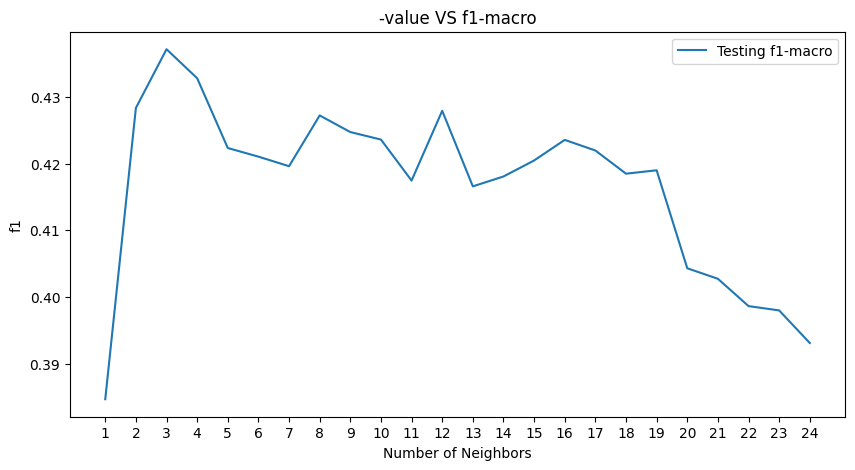

Best f1 is 0.4371594623763742 with K = 3


In [ ]:
# Model complexity
neig = np.arange(1, 25)
test_f1 = []

# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(embeddings_requests_bge_train, train["intent"])
    # Predict with knn
    prediction = knn.predict(embeddings_requests_bge_test)
    # test f1
    test_f1.append(f1_score(test["intent"], prediction, average='macro'))

# Plot
plt.figure(figsize=[10, 5])
plt.plot(neig, test_f1, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best f1 is {} with K = {}".format(np.max(test_f1), 1+test_f1.index(np.max(test_f1))))

Let's train the KNN classifier:

In [ ]:
K = 3  # Number of neighbors

# KNN-model
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
knn.fit(embeddings_requests_bge_train, train["intent"])

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [ ]:
prediction = knn.predict(embeddings_requests_bge_test)
f1_macro = f1_score(test["intent"], prediction, average='macro')  # f1-macro
print(f'With KNN (K={K}) f1-macro is: ', f1_macro)
print(f'With KNN (K={K}) accuracy is: ', knn.score(embeddings_requests_bge_test, test["intent"])) # accuracy

With KNN (K=3) f1-macro is:  0.4371594623763742
With KNN (K=3) accuracy is:  0.55668358714044


Let's visualize the clusters of embeddings:

In [ ]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    A function for visualizing the results of t-SNE
        :param data: features
        :param n_iter: the number of iterations for gradient descent,
            could be beneficial to increase to obtain better results
        :param perplexity: the number of neighbors
        :param color: np.array[n_samples] with variable,
            that we want to use to color our observations
        :return tsne_emb: np.array[n_samples, 2] - the results of t-SNE
    """

    # Let's start with PCA, as it provides a good initial approximation for t-SNE
    # This will allow the algorithm to converge faster
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)


    # Let's run t-SNE, it will give us 2 numbers for each object,
    # which we can to draw
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=int(os.environ.get('PYTHONHASHSEED')))
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # We will also return the results of t-SNE
    return tsne_embedding

In [ ]:
tsne_test_requests_bge = plot_tsne(embeddings_requests_bge_test,
                                  perplexity=K);

Let's color-code the predicted and ground truth intents differently:

In [ ]:
# Encoding text labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents_name)

# Color dictionary for labels
color_dict = {intents_name[i]: encoded_labels[i] for i in range(len(encoded_labels))}

# Creating a t-SNE plot for the first graph
trace1 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in prediction], colorscale='Jet', opacity=1),
                    text=prediction,
                    showlegend=False)

# Creating a t-SNE plot for the second graph
trace2 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in test["intent"]], colorscale='Jet', opacity=1),
                    text=test["intent"],
                    showlegend=False)

# Layout adjustments
layout1 = go.Layout(width=100, height=100)
layout2 = go.Layout(width=100, height=100)

# Creating figure for each graph
fig1 = go.Figure(data=[trace1], layout=layout1)
fig2 = go.Figure(data=[trace2], layout=layout2)

# Setting up subplot grid
fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Ground Truth"))

# Adding plots to a grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.show()

# 4 Fine-tuning BGEM3FlagModel sentence encoder

### Load dataset

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/datasets/sravni/sravni_train.csv')
train.head()

intent  \
0  /Пересекающиеся/Продлить полис   
1  /Пересекающиеся/Продлить полис   
2  /Пересекающиеся/Продлить полис   
3  /Пересекающиеся/Продлить полис   
4  /Пересекающиеся/Продлить полис   

                                        request  
0                          продлить полис осаго  
1                      мне нужно продлить полис  
2          нам нужно продлить полис страхования  
3  каким образом я могу продлить полис осаго от  
4                   помогите продлить страховку

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/datasets/sravni/sravni_test.csv')
test.head()

intent  \
0  /Системные/Сценарии для оператора/Перевод сраз...   
1          /Кредиты-займы/Почему просроченный платеж   
2  /Сравни ру/Внести изменения/Как изменить сведе...   
3                    /Пересекающиеся/Не пришёл полис   
4                      /Кредиты-займы/Закрыть кредит   

                                             request  
0  Прошу убрать из рассылок любого характера мой ...  
1  Здравствуйте. Я брал займ в мфо через приложен...  
2  Добрый день. Я оформила полис ОСАГО на вашем с...  
3  Два дня назад оплатил осаго, через сравни ру д...  
4  Здравствуйте, я через вас взял займ в миг кред...

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7964 entries, 0 to 7963
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   intent   7964 non-null   object
 1   request  7964 non-null   object
dtypes: object(2)
memory usage: 124.6+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   intent   591 non-null    object
 1   request  591 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [ ]:
intents_name = list(set(train['intent']) | set(test['intent']))
len(intents_name)

186

### Dataset generation

In [ ]:
def generate_positive_negative_pairs(dataset):
    # Grouping texts by classes
    grouped_texts = dataset.groupby('intent')['request'].apply(list)

    positive_pairs = []
    negative_pairs = []

    # Generating positive pairs for each class
    for intent, texts in grouped_texts.items():
        # Generating all possible combinations of texts
        positive_pairs.extend(combinations(texts, 2))

    # Generating negative pairs
    intents = grouped_texts.index.tolist()
    for i, intent_a in enumerate(intents):
        for j, intent_b in enumerate(intents):
            if i != j:  # Excluding pairs from the same class
                texts_a = grouped_texts[intent_a]
                texts_b = grouped_texts[intent_b]
                for text_a in texts_a:
                    for text_b in texts_b:
                        negative_pairs.append((text_a, text_b))

    return positive_pairs, negative_pairs

In [ ]:
# Generating positive and negative pairs of texts
positive_pairs, negative_pairs = generate_positive_negative_pairs(train)
print(f"Позитивных пар: {len(positive_pairs)}\nНегативных пар: {len(negative_pairs)}")

Позитивных пар: 477972
Негативных пар: 62461388


In [ ]:
# Creating a DataFrame for positive pairs
positive_df = pd.DataFrame(positive_pairs, columns=['request1', 'request2'])

# Creating a DataFrame for negative pairs
negative_df = pd.DataFrame(negative_pairs, columns=['request1', 'request2'])
neg_num = round(len(positive_pairs) / len(negative_df["request1"].unique()))
negative_df = negative_df.groupby('request1').apply(lambda x: x.sample(n=neg_num,
                                                                       random_state=int(os.environ.get('PYTHONHASHSEED'))))
negative_df = negative_df.reset_index(drop=True)

# Adding the 'is_positive' column and assigning values
positive_df['is_positive'] = 1
negative_df['is_positive'] = 0

# Concatenating DataFrames for positive and negative pairs
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Let's create a dictionary of all unique requests using a dictionary generator
request_dict = {i + 1: request for i, request in enumerate(train['request'].unique())}

# Generating values for the 'rid1' and 'rid2' columns
combined_df['rid1'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request1']]
combined_df['rid2'] = [next((key for key, val in request_dict.items() if val == value), None) for value in combined_df['request2']]

# Reordering columns in the desired order
combined_df = combined_df[['rid1', 'rid2', 'request1', 'request2', 'is_positive']]

display(combined_df)

rid1  rid2                                           request1  \
0       5096  5097  почему в разное время цена полиса разная от од...   
1       5096  5098  почему в разное время цена полиса разная от од...   
2       5096  5099  почему в разное время цена полиса разная от од...   
3       5096  5100  почему в разное время цена полиса разная от од...   
4       5096  5101  почему в разное время цена полиса разная от од...   
...      ...   ...                                                ...   
955807  2545  1012                                          ясен пень   
955808  2545  2307                                          ясен пень   
955809  2545  1987                                          ясен пень   
955810  2545  2305                                          ясен пень   
955811  2545  6762                                          ясен пень   

                                                 request2  is_positive  
0       почему стоимость осаго при оплате увеличиваетс...            1  
1       предложено 4774 при оплате цена возрастает на ...            1  
2               почему меняеться цена на осаго при оплате            1  
3       цена указана но было написано что есть предлож...            1  
4       почему при оформлении полиса у меня резко меня...            1  
...                                                   ...          ...  
955807                как добавить водителя в полис осаго            0  
955808                    со мной может не робом общаться            0  
955809                                              салам            0  
955810         роботизированно отправлять ответ не хорошо            0  
955811                                     так где ответы            0  

[955812 rows x 5 columns]

In [ ]:
data_requests = {}  # Mapping of relevant request for a given request
reqs = []  # request2 ids for filtering

for index, row in combined_df[combined_df['is_positive'] == 1].sort_values(by='rid1').iterrows():
  if row["request2"] in reqs:
    continue
  else:
    data_requests[row["request1"]] = data_requests.get(row["request1"], []) + [row["request2"]]
    reqs.append(row["request2"])

In [ ]:
data_bge3_finetuning = []

for key, value in data_requests.items():
  temp = {}
  temp["query"] = key
  temp["pos"] = value
  temp["neg"] = negative_df[negative_df["request1"] == key]["request2"].to_list()

  data_bge3_finetuning.append(temp)

In [ ]:
data_bge3_finetuning

[{'query': 'продлить полис осаго',
  'pos': ['можно будет продлить',
   'продлить полюс в личном кабинете',
   'как продлить полюс осаго на пол года',
   'подскажите как продлить полюс  он у меня есть но на 3 месяца',
   'через ваше приложение возможно продление осаго',
   'нам нужно продлить полис страхования',
   'хочу продлить полис осаго но у моей страховой расчет недоступен почему',
   'какие документы и данные мне потребуются для продления страхового полиса',
   'хочу продлить мой страховой полис какие шаги мне нужно предпринять',
   'каким образом я могу продлить полис осаго от',
   'помогите продлить страховку',
   'могу я продлить страховку без заполнения',
   'мой текущий полис скоро истекает как я могу его продлить',
   'полис до 7 октября действует когда его можно будет пролонгировать',
   'необходима продлить каско и осаго',
   'хочу продлить осаго а не вводить все заново ',
   'мне нужно продлить полис на автомобиль как это сделать',
   'пожалуйста помогите мне продлить м

In [ ]:
# File path to save the data
file_path = "data_bge-m3.jsonl"

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate through the list of dictionaries
    for entry in data_bge3_finetuning:
        # Convert the dictionary to a JSON string
        json_line = json.dumps(entry, ensure_ascii=False)
        # Write the JSON string to the file, followed by a newline character
        file.write(json_line + '\n')

### bge-m3 (BGEM3FlagModel) training

In [ ]:
import wandb
from google.colab import userdata

wandb_key = userdata.get("wandb")
wandb.login(key=wandb_key, anonymous="never")

In [ ]:
num_epochs = 500

In [ ]:
model_save_path = "output/BGEM3FlagModel_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(model_save_path, exist_ok=True)

In [ ]:
!torchrun --nproc_per_node 1 \
-m FlagEmbedding.baai_general_embedding.finetune.run \
--output_dir {model_save_path} \
--model_name_or_path BAAI/bge-m3 \
--train_data ./{file_path} \
--learning_rate 1e-5 \
--fp16 \
--num_train_epochs {num_epochs} \
--per_device_train_batch_size 32 \
--dataloader_drop_last True \
--normlized True \
--temperature 0.02 \
--query_max_len 256 \
--passage_max_len 256 \
--train_group_size 2 \
--negatives_cross_device \
--logging_steps 10 \
--save_steps 1000 \
--query_instruction_for_retrieval "" \
--seed {int(os.environ.get('PYTHONHASHSEED'))}

2024-05-02 21:08:27.242024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 21:08:27.242074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 21:08:27.243846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 21:08:28.381641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/02/2024 21:08:30 - WARNING - __main__ -   Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: True, 16-bits training: True
05/02/2024 21:08:30 - INFO - __main__ -   Training/evaluation parameters RetrieverTrainingArguments(
_

In [ ]:
model = BGEM3FlagModel(model_save_path)

Let's generate embeddings from the dataset:

In [ ]:
embeddings_requests_bge_train = model.encode(list(train["request"]))['dense_vecs']
embeddings_requests_bge_test = model.encode(list(test["request"]))['dense_vecs']

Inference Embeddings: 100%|██████████| 50/50 [00:01<00:00, 45.06it/s]


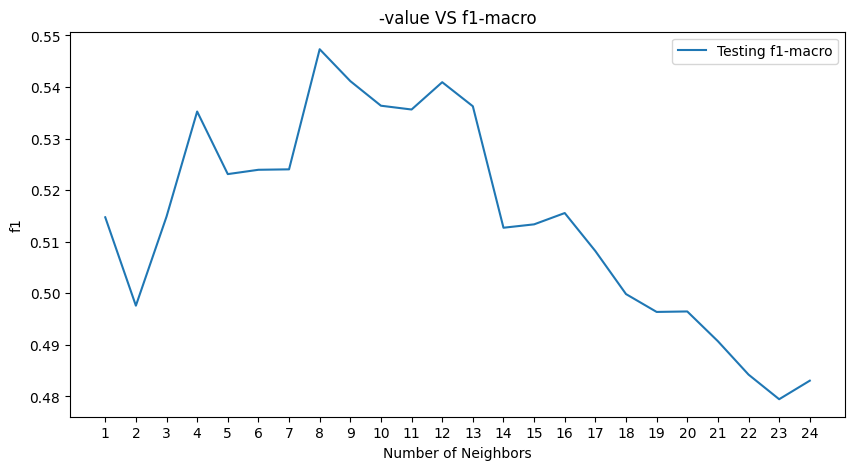

Best f1 is 0.5473331270635825 with K = 8


In [ ]:
# Model complexity
neig = np.arange(1, 25)
test_f1 = []

# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(embeddings_requests_bge_train, train["intent"])
    # Predict with knn
    prediction = knn.predict(embeddings_requests_bge_test)
    # test f1
    test_f1.append(f1_score(test["intent"], prediction, average='macro'))

# Plot
plt.figure(figsize=[10, 5])
plt.plot(neig, test_f1, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best f1 is {} with K = {}".format(np.max(test_f1), 1+test_f1.index(np.max(test_f1))))

Let's train the KNN classifier:

In [ ]:
K = 8  # Number of neighbors

# KNN-model
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
knn.fit(embeddings_requests_bge_train, train["intent"])

KNeighborsClassifier(metric='cosine', n_neighbors=8)

In [ ]:
prediction = knn.predict(embeddings_requests_bge_test)
f1_macro = f1_score(test["intent"], prediction, average='macro')  # f1-macro
print(f'With KNN (K={K}) f1-macro is: ', f1_macro)
print(f'With KNN (K={K}) accuracy is: ', knn.score(embeddings_requests_bge_test, test["intent"])) # accuracy

With KNN (K=8) f1-macro is:  0.5473021486599553
With KNN (K=8) accuracy is:  0.6835871404399323


Let's visualize the clusters of embeddings:

In [ ]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    A function for visualizing the results of t-SNE
        :param data: features
        :param n_iter: the number of iterations for gradient descent,
            could be beneficial to increase to obtain better results
        :param perplexity: the number of neighbors
        :param color: np.array[n_samples] with variable,
            that we want to use to color our observations
        :return tsne_emb: np.array[n_samples, 2] - the results of t-SNE
    """

    # Let's start with PCA, as it provides a good initial approximation for t-SNE
    # This will allow the algorithm to converge faster
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)


    # Let's run t-SNE, it will give us 2 numbers for each object,
    # which we can to draw
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=int(os.environ.get('PYTHONHASHSEED')))
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # We will also return the results of t-SNE
    return tsne_embedding

<ipython-input-50-2cb600546557>:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


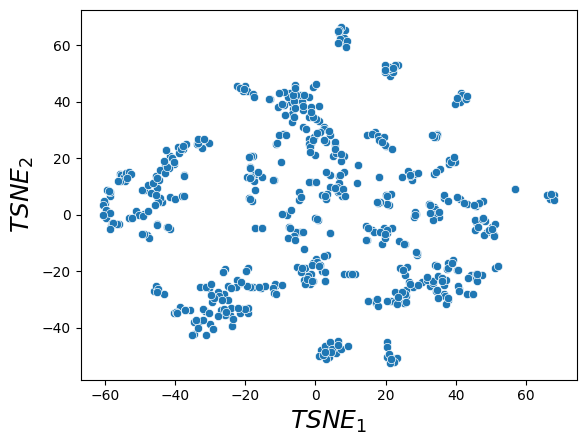

In [ ]:
tsne_test_requests_bge = plot_tsne(embeddings_requests_bge_test,
                                  perplexity=K);

Let's color-code the predicted and ground truth intents differently:

In [ ]:
# Encoding text labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(intents_name)

# Color dictionary for labels
color_dict = {intents_name[i]: encoded_labels[i] for i in range(len(encoded_labels))}

# Creating a t-SNE plot for the first graph
trace1 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in prediction], colorscale='Jet', opacity=1),
                    text=prediction,
                    showlegend=False)

# Creating a t-SNE plot for the second graph
trace2 = go.Scatter(x=tsne_test_requests_bge[:, 0],
                    y=tsne_test_requests_bge[:, 1],
                    mode='markers',
                    marker=dict(color=[color_dict[_] for _ in test["intent"]], colorscale='Jet', opacity=1),
                    text=test["intent"],
                    showlegend=False)

# Layout adjustments
layout1 = go.Layout(width=100, height=100)
layout2 = go.Layout(width=100, height=100)

# Creating figure for each graph
fig1 = go.Figure(data=[trace1], layout=layout1)
fig2 = go.Figure(data=[trace2], layout=layout2)

# Setting up subplot grid
fig = make_subplots(rows=1, cols=2, subplot_titles=("Predictions", "Ground Truth"))

# Adding plots to a grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.show()